# NBA Players Shot Type
Muhammad Najmi Naufal

The goal is to conduct an unsupervised modeling of these datasets using  K-Means, DBSCAN, Spectral Clustering, and Agglomerative Clustering model algorithms.<br/>
<br/>
Dataset Source:<br/>
https://www.kaggle.com/datasets/drgilermo/nba-players-stats-20142015<br/>
https://www.kaggle.com/datasets/dansbecker/nba-shot-logs

Dataset 1 ('players_stats.csv')<br/>
Full players stats from the 2014-2015 season + personal details such as height. weight, etc.<br/>
This data set can be paired with the shot logs data set from the same season.<br/>
<br/>
The data was scraped and copied from:<br/>
http://www.basketball-reference.com/teams/<br/>
and<br/>
http://stats.nba.com/leaders#!?Season=2014-15&SeasonType=Regular%20Season&StatCategory=MIN&CF=MING2&PerMode=Totals<br/>
<br/>
Dataset 2 ('shot_logs.csv')<br/>
Data on shots taken during the 2014-2015 season, who took the shot, where on the floor was the shot taken from, who was the nearest defender, how far away was the nearest defender, time on the shot clock, and much more. The column titles are generally self-explanatory.<br/>
Useful for evaluating who the best shooter is, who the best defender is, the hot-hand hypothesis, etc.<br/><br/>
Scraped from NBA's REST API.

## Import Libraries

In [1]:
# general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import feature_engine
import statsmodels
import warnings

In [2]:
# sklearn and other modules
from feature_engine.outliers import Winsorizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

In [3]:
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# load data as pandas DataFrame
df1 = pd.read_csv('players_stats.csv')
df2 = pd.read_csv('shot_logs.csv')

### datasets merging

In [5]:
df1.Name = df1.Name.str.lower()

In [6]:
df3 = df2.merge(df1, left_on='player_name', right_on='Name', how='left')
df3.Name.isna().sum()

8603

In [7]:
name_old = df3.loc[df3.Name.isna()]['player_name'].unique().tolist()
name_old

['jon ingles',
 'otto porter',
 'nene hilario',
 'jimmer dredette',
 'mnta ellis',
 'jose juan barea',
 'al farouq aminu',
 'dirk nowtizski',
 'kyle oquinn',
 'cj watson',
 'danilo gallinai',
 'nerles noel',
 'oj mayo',
 'beno urdih',
 'amare stoudemire',
 'time hardaway jr',
 'dj augustin',
 'dwayne wade',
 'james ennis',
 'steve adams',
 'alan crabbe']

In [8]:
name_new = ['joe ingles', 'otto porter jr.', 'nene', 'jimmer fredette', 'monta ellis', 'j.j. barea',
            'al-farouq aminu', 'dirk nowitzki', "kyle o'quinn", 'c.j. watson', 'danilo gallinari', 
            'nerlens noel', 'o.j. mayo', 'beno udrih', "amar'e stoudemire", 'tim hardaway jr.',
            'd.j. augustin', 'dwyane wade', 'james ennis iii', 'steven adams', 'allen crabbe']

In [9]:
df2.player_name = df2.player_name.replace(name_old, name_new)

In [10]:
df4 = df2.merge(df1, left_on='player_name', right_on='Name', how='left')
df4.Name.isna().sum()

0

### data checking

In [11]:
# original dataset copy
data = df4.copy()
data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,30.0,us,"December 3, 1985",University of Dayton,2,182.5,PG,CHA,77.85,23.373991
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,30.0,us,"December 3, 1985",University of Dayton,2,182.5,PG,CHA,77.85,23.373991
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,30.0,us,"December 3, 1985",University of Dayton,2,182.5,PG,CHA,77.85,23.373991
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,30.0,us,"December 3, 1985",University of Dayton,2,182.5,PG,CHA,77.85,23.373991
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,30.0,us,"December 3, 1985",University of Dayton,2,182.5,PG,CHA,77.85,23.373991


In [12]:
# columns name, number of non-nulls, and data type 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128069 entries, 0 to 128068
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [13]:
# number of unique values in columns
data.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM_x                            2
PTS_x                            3
player_name                    281
player_id                      281
Name                           281
Games Played                    44
MIN                            261
PTS_y                          255
FGM_y                          214
FGA                            252
FG%                            155
3PM                 

In [14]:
# general statistic description
data.describe().T

,count,mean,std,min,25%,50%,75%,max
GAME_ID,128069.0,2.140045e+07,257.877259,2.140000e+07,21400233.00,21400449.00,2.140067e+07,2.140091e+07
FINAL_MARGIN,128069.0,2.087234e-01,13.233267,-5.300000e+01,-8.00,1.00,9.000000e+00,5.300000e+01
SHOT_NUMBER,128069.0,6.506899e+00,4.713260,1.000000e+00,3.00,5.00,9.000000e+00,3.800000e+01
PERIOD,128069.0,2.469427e+00,1.139919,1.000000e+00,1.00,2.00,3.000000e+00,7.000000e+00
SHOT_CLOCK,122502.0,1.245334e+01,5.763265,0.000000e+00,8.20,12.30,1.667500e+01,2.400000e+01
DRIBBLES,128069.0,2.023355e+00,3.477760,0.000000e+00,0.00,1.00,2.000000e+00,3.200000e+01
TOUCH_TIME,128069.0,2.765901e+00,3.043682,-1.636000e+02,0.90,1.60,3.700000e+00,2.490000e+01
SHOT_DIST,128069.0,1.357150e+01,8.888964,0.000000e+00,4.70,13.70,2.250000e+01,4.720000e+01
PTS_TYPE,128069.0,2.264670e+00,0.441159,2.000000e+00,2.00,2.00,3.000000e+00,3.000000e+00
CLOSEST_DEFENDER_PLAYER_ID,128069.0,1.590385e+05,78791.172947,7.080000e+02,101249.00,201949.00,2.030790e+05,5.300270e+05


## Exploratory Data Analysis (EDA)

In [15]:
# object columns check
cat_col = data.select_dtypes(include=['object']).columns.tolist()
data[cat_col].head()

,MATCHUP,LOCATION,W,GAME_CLOCK,SHOT_RESULT,CLOSEST_DEFENDER,player_name,Name,Birth_Place,Birthdate,Collage,Experience,Pos,Team
0,"MAR 04, 2015 - CHA @ BKN",A,W,1:09,made,"Anderson, Alan",brian roberts,brian roberts,us,"December 3, 1985",University of Dayton,2,PG,CHA
1,"MAR 04, 2015 - CHA @ BKN",A,W,0:14,missed,"Bogdanovic, Bojan",brian roberts,brian roberts,us,"December 3, 1985",University of Dayton,2,PG,CHA
2,"MAR 04, 2015 - CHA @ BKN",A,W,0:00,missed,"Bogdanovic, Bojan",brian roberts,brian roberts,us,"December 3, 1985",University of Dayton,2,PG,CHA
3,"MAR 04, 2015 - CHA @ BKN",A,W,11:47,missed,"Brown, Markel",brian roberts,brian roberts,us,"December 3, 1985",University of Dayton,2,PG,CHA
4,"MAR 04, 2015 - CHA @ BKN",A,W,10:34,missed,"Young, Thaddeus",brian roberts,brian roberts,us,"December 3, 1985",University of Dayton,2,PG,CHA


In [16]:
# convert 'GAME_CLOCK' to total seconds
data.GAME_CLOCK = pd.to_timedelta('00:' + data.GAME_CLOCK).dt.total_seconds()

# replace 'R' (rookie) to 0 in 'Experience'
data.Experience.replace('R', 0, inplace=True)

# convert 'Experience' to numeric
data.Experience = pd.to_numeric(data.Experience, errors='coerce')

# position numbering convention 
pos_dict = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

# convert 'Pos' to numeric
data.Pos = data.Pos.map(pos_dict)

data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,69.0,10.8,2,...,30.0,us,"December 3, 1985",University of Dayton,2.0,182.5,1.0,CHA,77.85,23.373991
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,14.0,3.4,0,...,30.0,us,"December 3, 1985",University of Dayton,2.0,182.5,1.0,CHA,77.85,23.373991
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0.0,NaN,3,...,30.0,us,"December 3, 1985",University of Dayton,2.0,182.5,1.0,CHA,77.85,23.373991
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,707.0,10.3,2,...,30.0,us,"December 3, 1985",University of Dayton,2.0,182.5,1.0,CHA,77.85,23.373991
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,634.0,10.9,2,...,30.0,us,"December 3, 1985",University of Dayton,2.0,182.5,1.0,CHA,77.85,23.373991


In [17]:
# exploratory plots function, displays data distribution and correlation
def exploratory_plots(df, col):
    corr_df = pd.DataFrame({'col_corr' : df.corr()[col]}).reset_index()
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=10)
    
    plt.subplot(1, 2, 2)
    corr_plot = sns.barplot(x='index', y='col_corr', data=corr_df, palette='Set2')
    corr_plot.set_xticklabels([])

    plt.show()

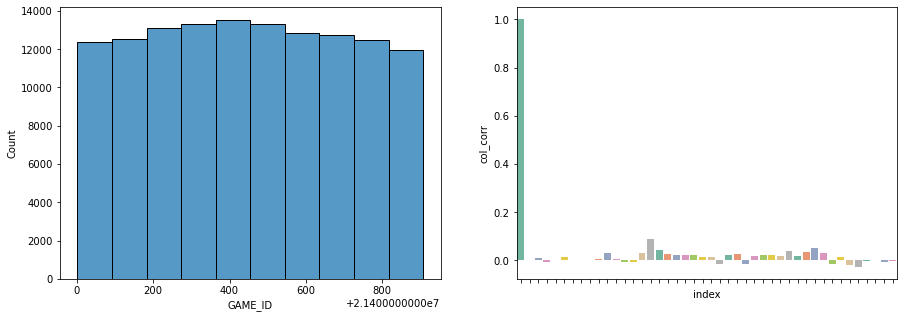

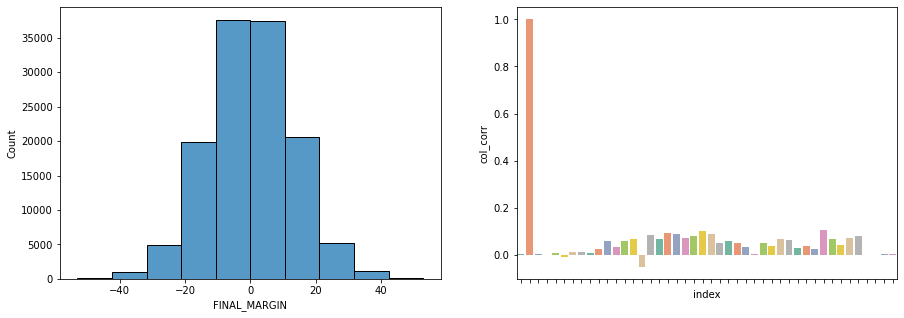

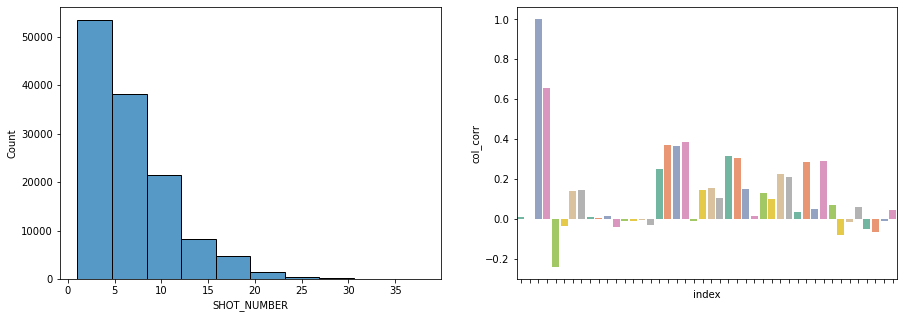

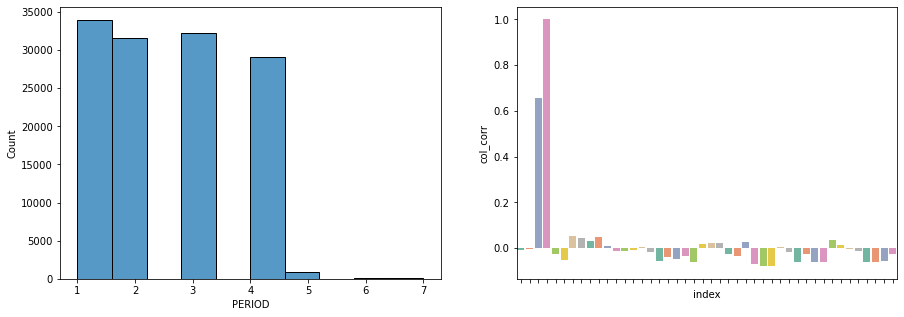

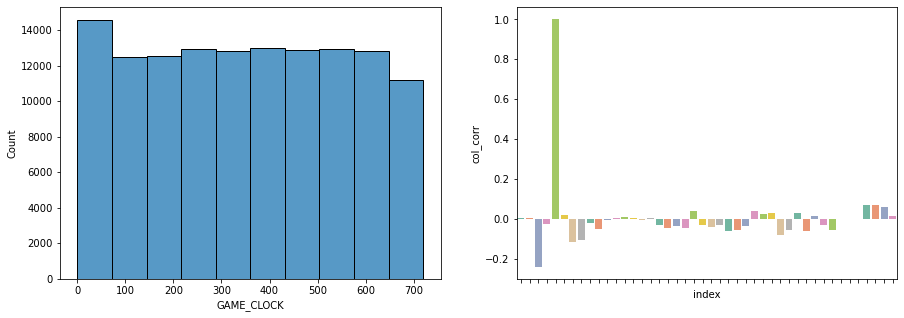

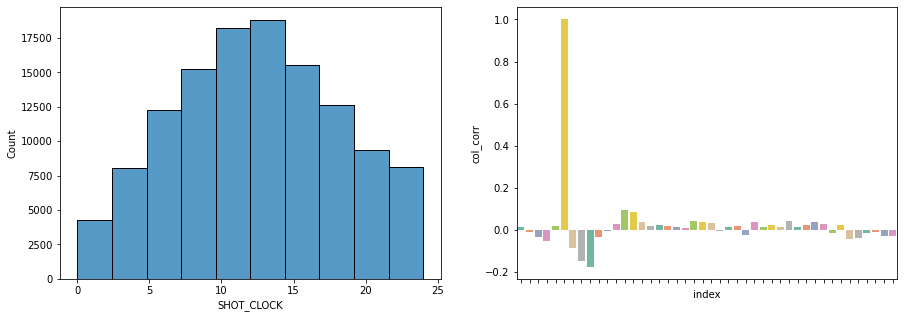

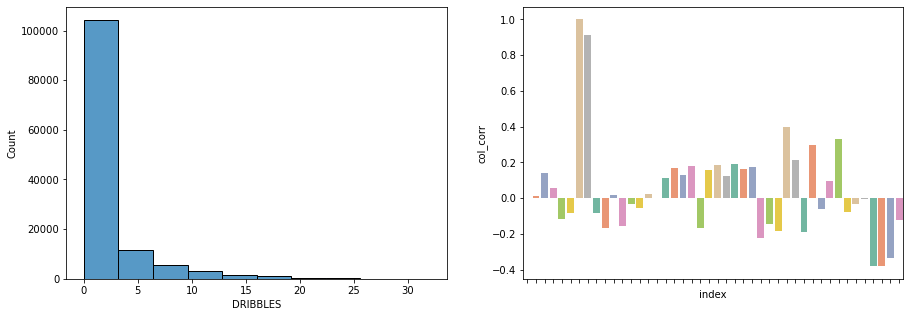

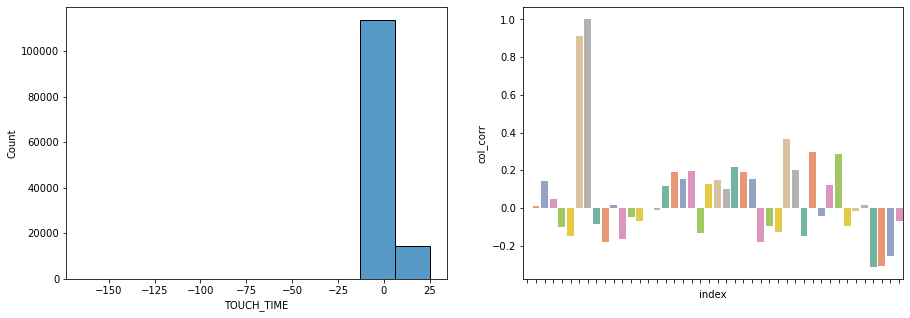

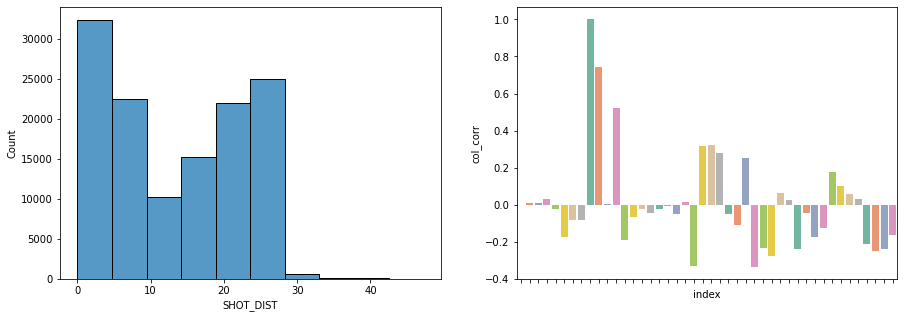

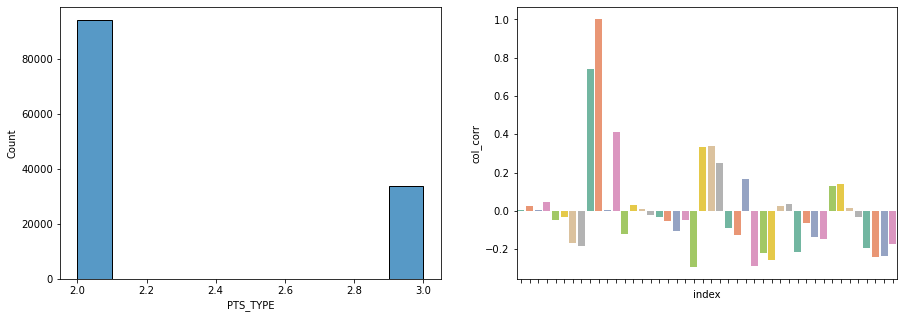

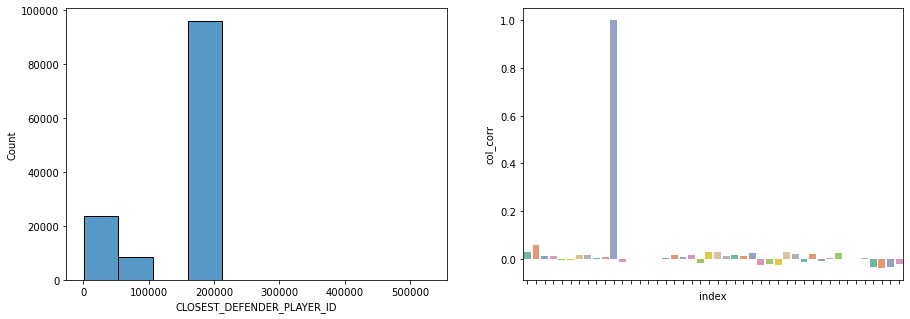

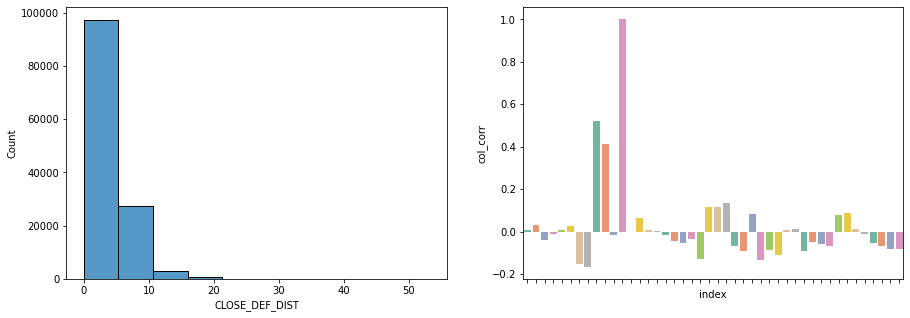

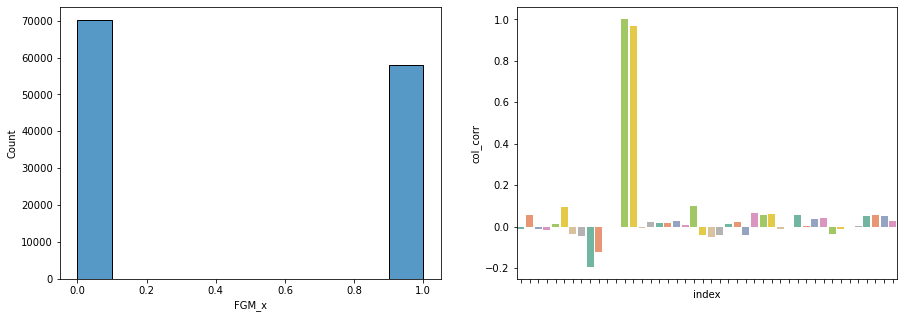

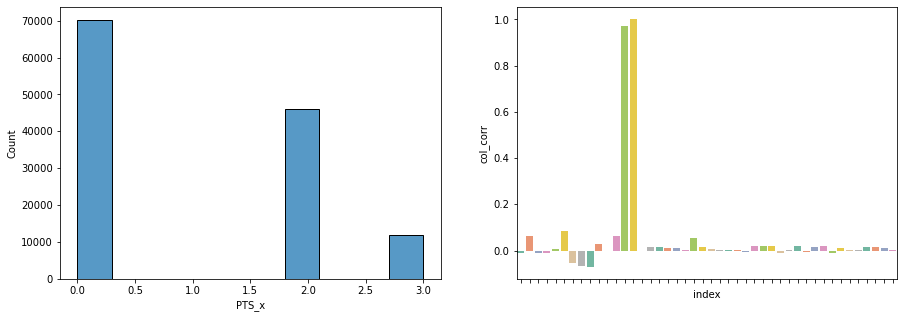

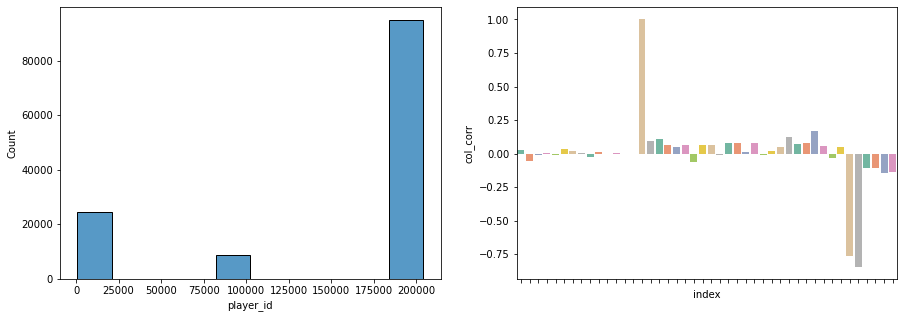

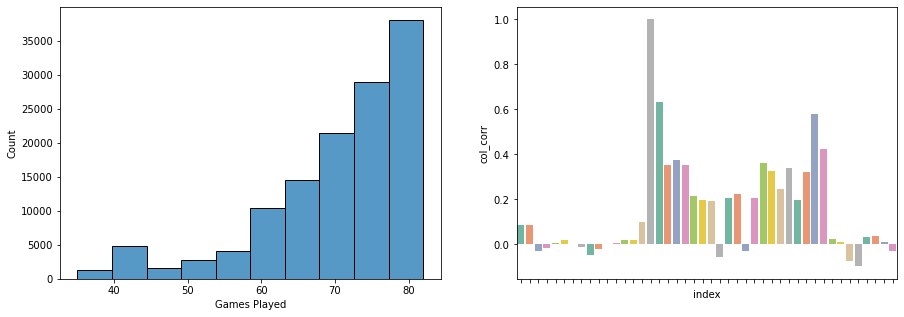

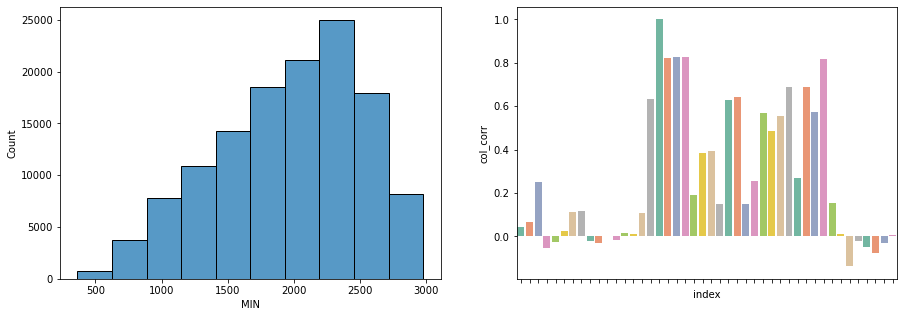

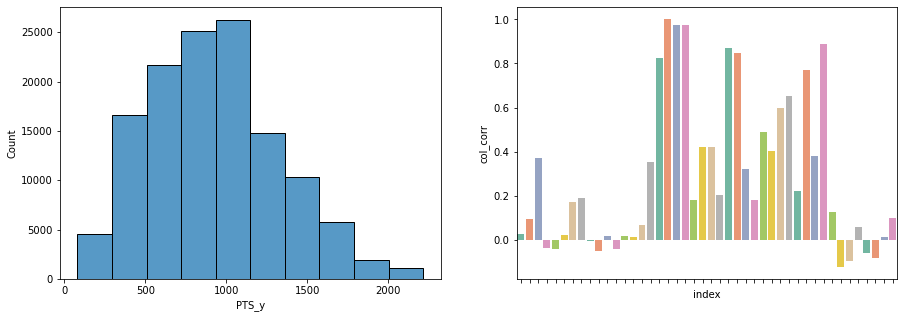

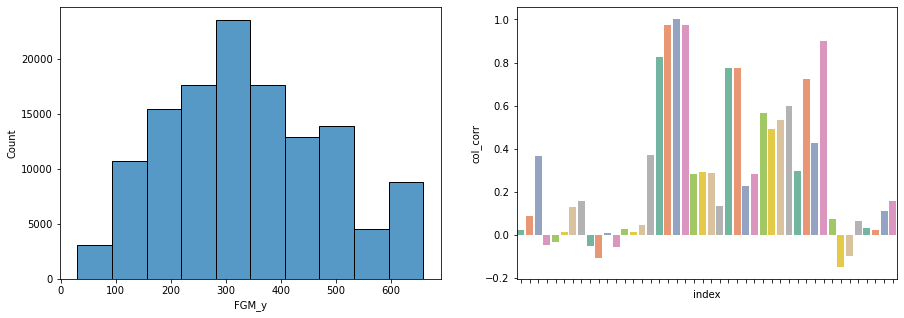

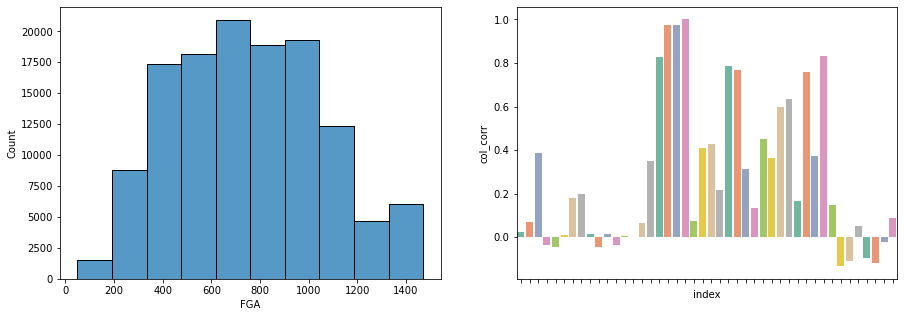

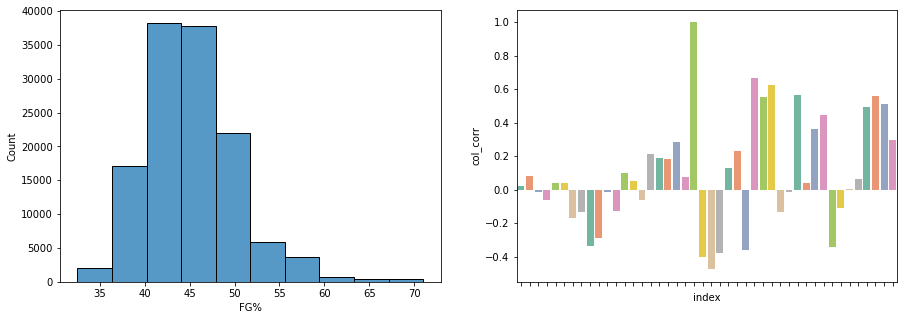

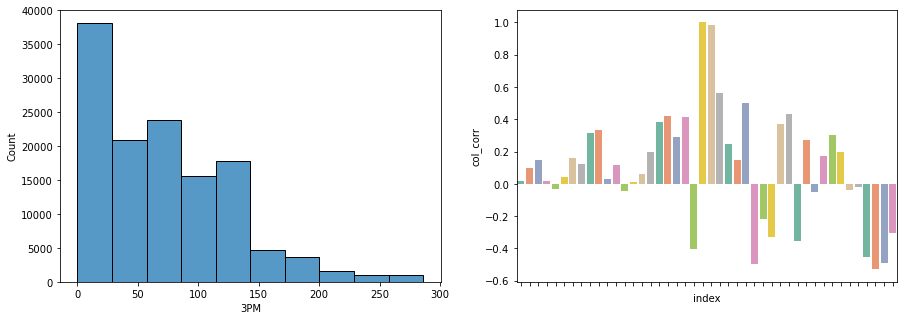

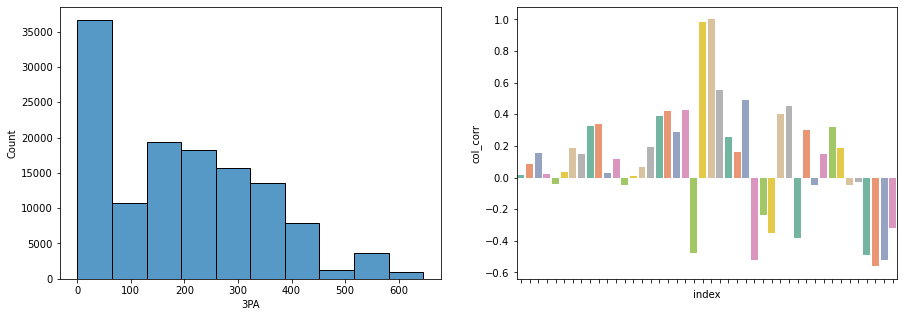

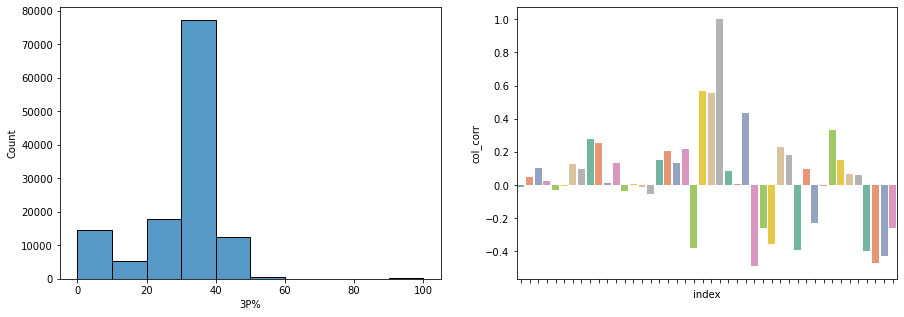

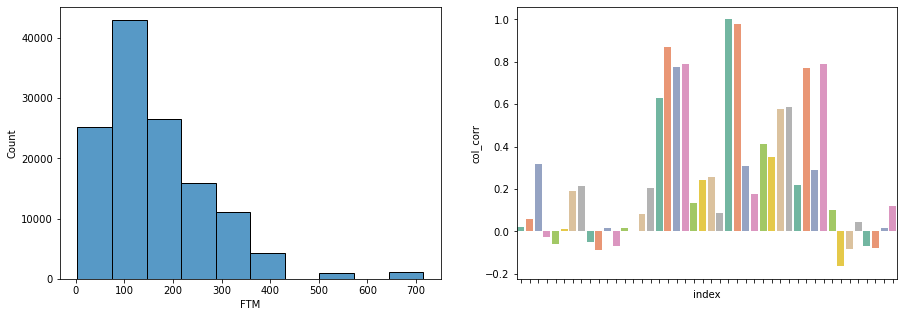

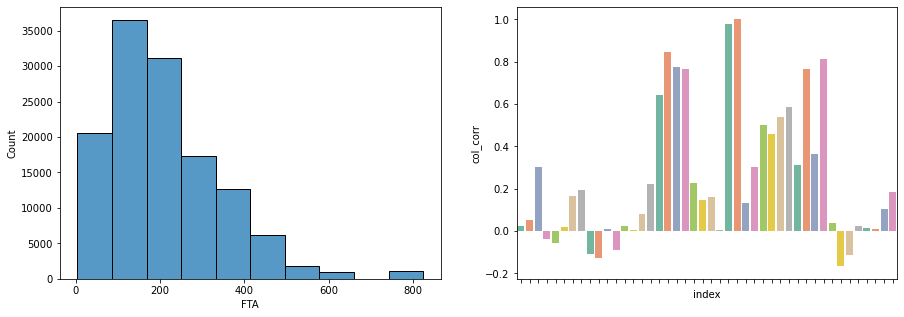

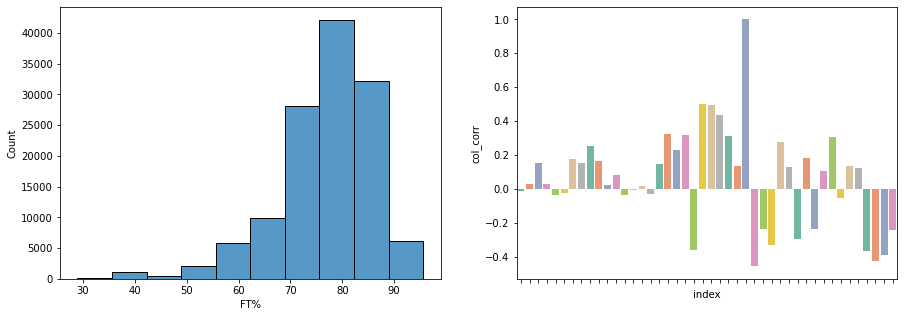

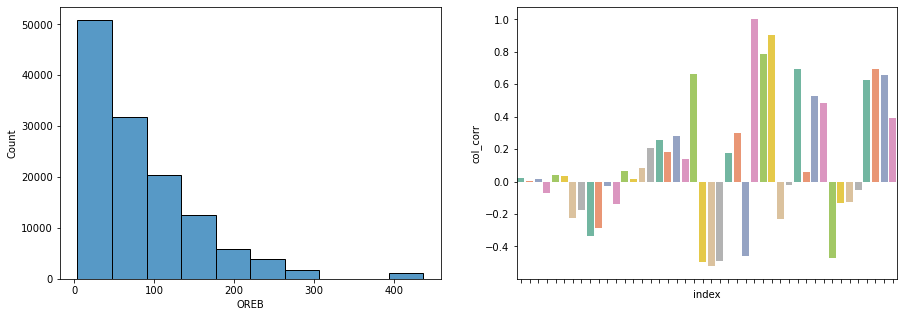

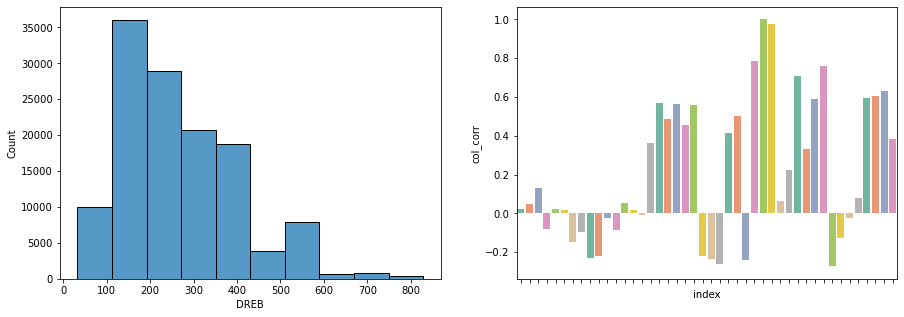

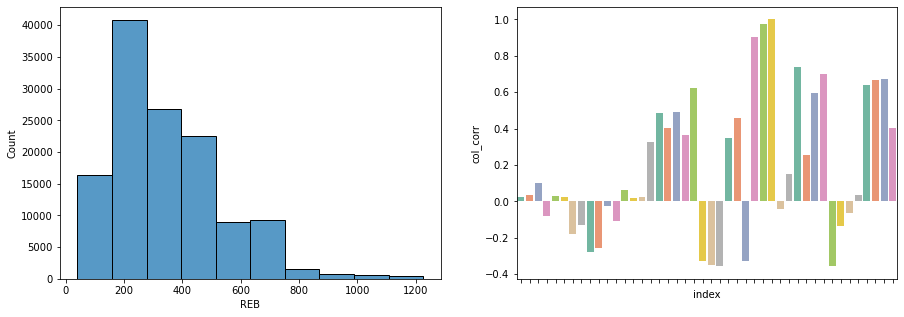

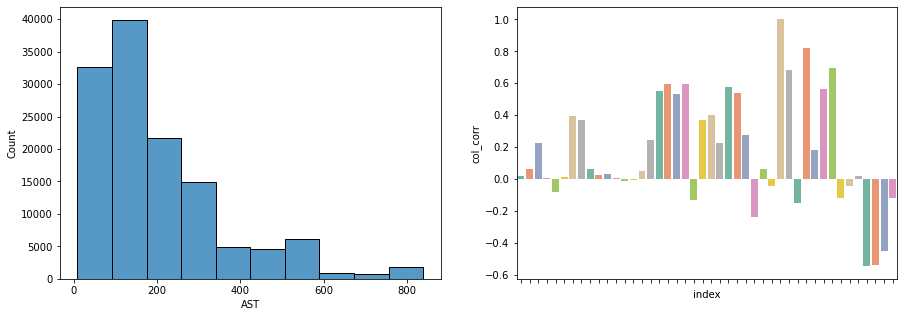

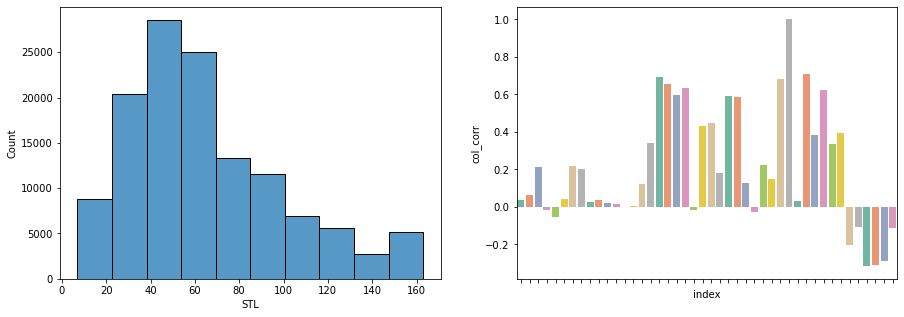

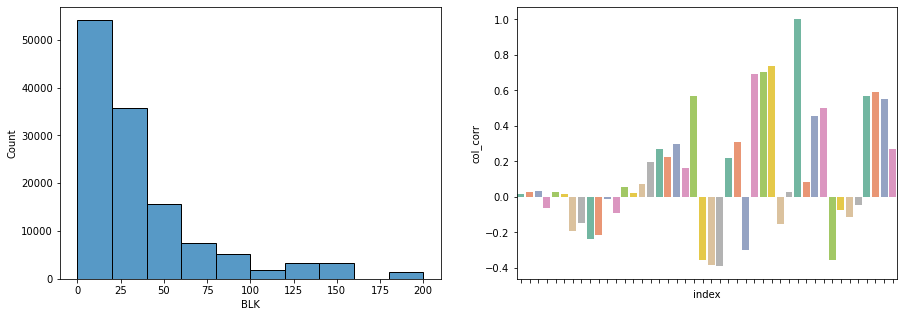

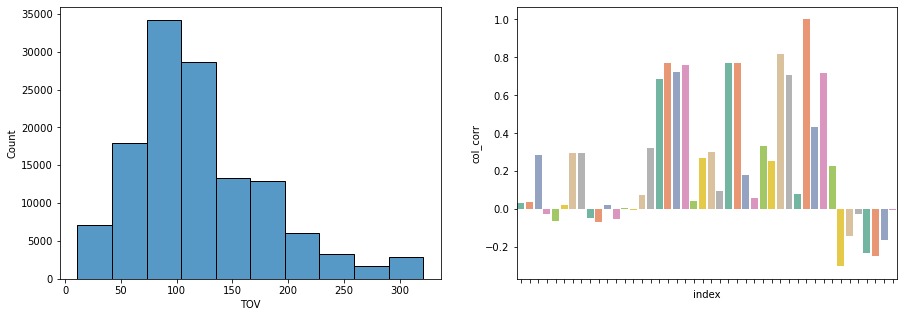

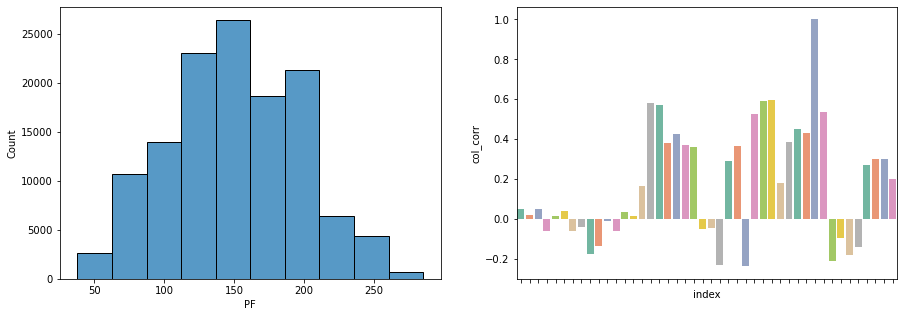

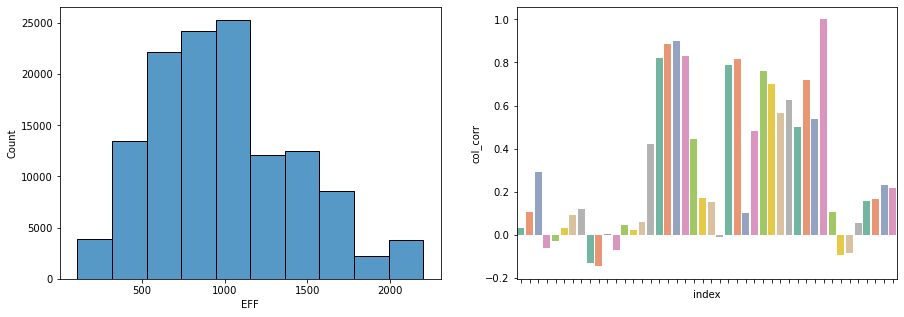

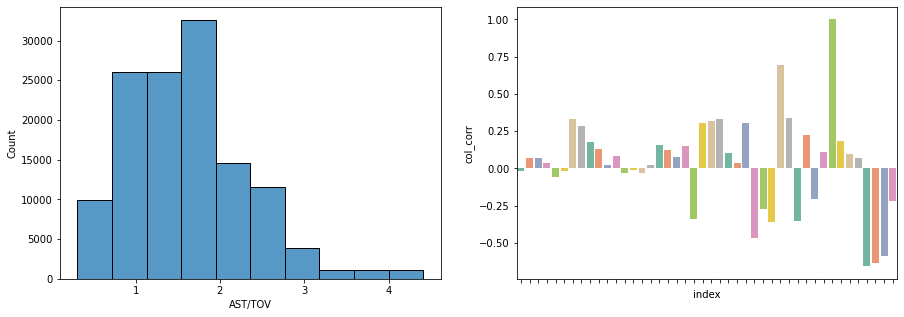

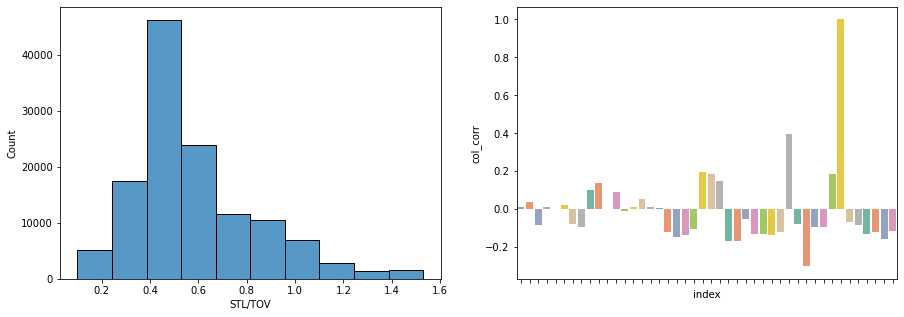

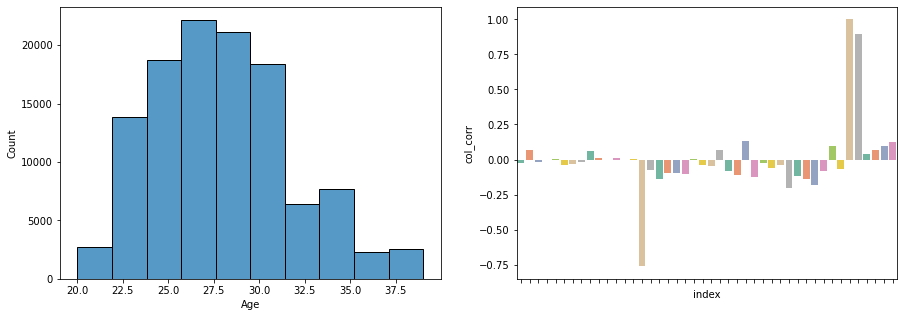

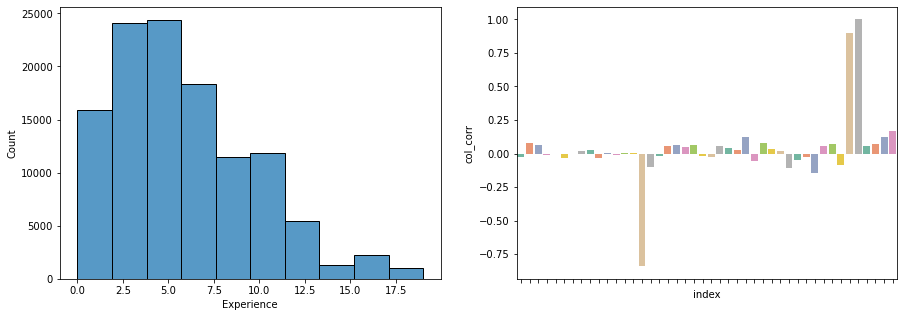

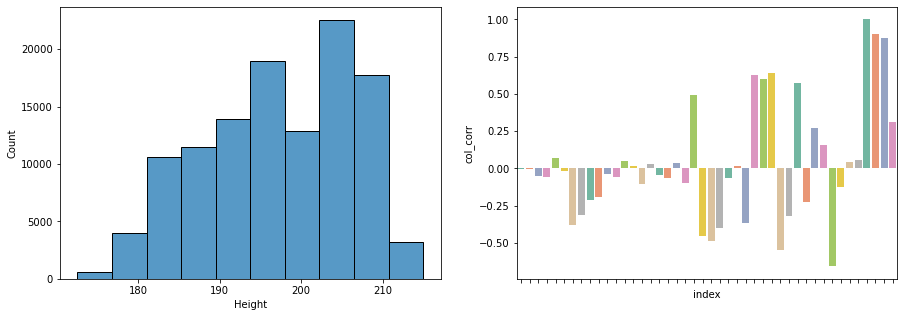

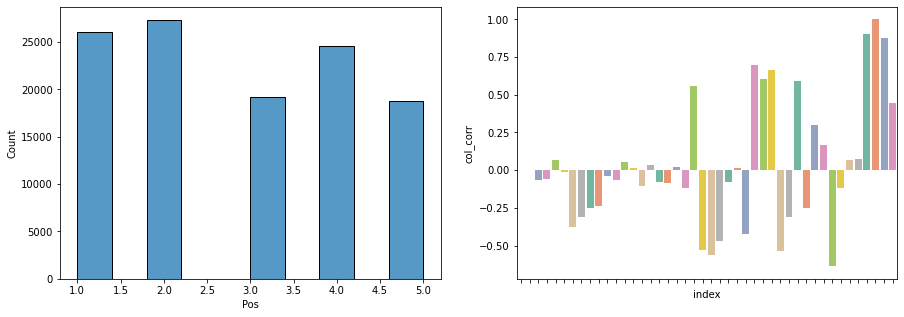

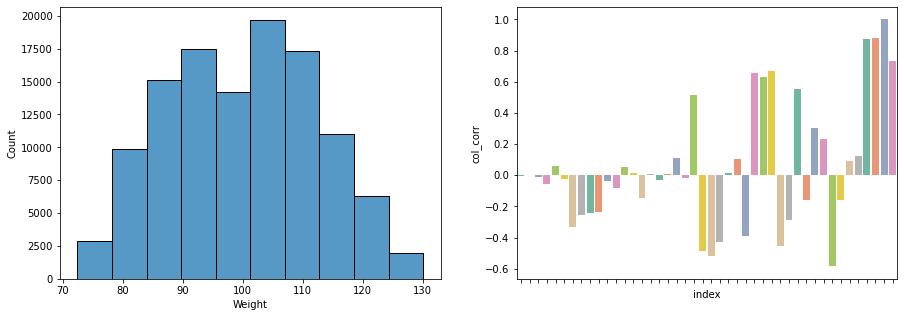

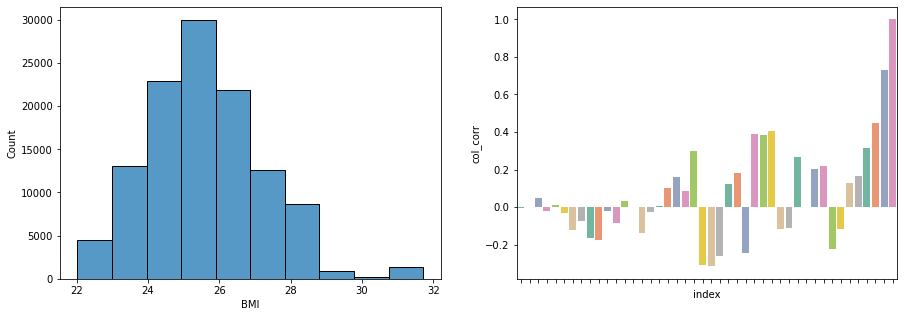

In [18]:
# numeric columns list
num_col = data.select_dtypes(include=np.number).columns.tolist()

# exploratory_plots of num_col 
for col in num_col :
    exploratory_plots(data, col)

In [19]:
# normal distribution columns list
col_norm = ['FINAL_MARGIN', 'SHOT_CLOCK']

# skew distribution columns list
col_skew = [item for item in num_col if item not in col_norm]

## Data Preprocessing

In [20]:
# missing value detection
data.isna().sum()

GAME_ID                           0
MATCHUP                           0
LOCATION                          0
W                                 0
FINAL_MARGIN                      0
SHOT_NUMBER                       0
PERIOD                            0
GAME_CLOCK                        0
SHOT_CLOCK                     5567
DRIBBLES                          0
TOUCH_TIME                        0
SHOT_DIST                         0
PTS_TYPE                          0
SHOT_RESULT                       0
CLOSEST_DEFENDER                  0
CLOSEST_DEFENDER_PLAYER_ID        0
CLOSE_DEF_DIST                    0
FGM_x                             0
PTS_x                             0
player_name                       0
player_id                         0
Name                              0
Games Played                      0
MIN                               0
PTS_y                             0
FGM_y                             0
FGA                               0
FG%                         

In [21]:
data.loc[data.SHOT_CLOCK.isna()]['player_name'].value_counts().head()

jordan hill      92
carlos boozer    82
nick young       79
john wall        79
jeremy lin       70
Name: player_name, dtype: int64

In [22]:
data.loc[data.Age.isna()]['player_name'].value_counts().head()

russell westbrook    969
john wall            874
andrew wiggins       797
dwyane wade          703
thaddeus young       694
Name: player_name, dtype: int64

In [23]:
data.loc[data.Experience.isna()]['player_name'].value_counts().head()

russell westbrook    969
john wall            874
andrew wiggins       797
dwyane wade          703
thaddeus young       694
Name: player_name, dtype: int64

In [24]:
data.loc[data.Height.isna()]['player_name'].value_counts().head()

russell westbrook    969
john wall            874
andrew wiggins       797
dwyane wade          703
thaddeus young       694
Name: player_name, dtype: int64

In [25]:
data.loc[data.Pos.isna()]['player_name'].value_counts().head()

russell westbrook    969
john wall            874
andrew wiggins       797
dwyane wade          703
thaddeus young       694
Name: player_name, dtype: int64

In [26]:
data.loc[data.Weight.isna()]['player_name'].value_counts().head()

russell westbrook    969
john wall            874
andrew wiggins       797
dwyane wade          703
thaddeus young       694
Name: player_name, dtype: int64

In [27]:
data_rw = data.query("player_name == 'russell westbrook'")
val_rw = {"Age": 26, "Experience": 6, "Height": 190, "Pos": 1, "Weight": 90}
data_rw.fillna(value=val_rw, inplace=True)
data = pd.concat([data[~data.index.isin(data_rw.index)], data_rw])

data_jw = data.query("player_name == 'john wall'")
val_jw = {"Age": 24, "Experience": 4, "Height": 190, "Pos": 1, "Weight": 95}
data_jw.fillna(value=val_jw, inplace=True)
data = pd.concat([data[~data.index.isin(data_jw.index)], data_jw])

data_aw = data.query("player_name == 'andrew wiggins'")
val_aw = {"Age": 19, "Experience": 0, "Height": 201, "Pos": 3, "Weight": 89}
data_aw.fillna(value=val_aw, inplace=True)
data = pd.concat([data[~data.index.isin(data_aw.index)], data_aw])

data_dw = data.query("player_name == 'dwyane wade'")
val_dw = {"Age": 33, "Experience": 11, "Height": 193, "Pos": 2, "Weight": 99}
data_dw.fillna(value=val_dw, inplace=True)
data = pd.concat([data[~data.index.isin(data_dw.index)], data_dw])

data_ty = data.query("player_name == 'thaddeus young'")
val_ty = {"Age": 26, "Experience": 7, "Height": 203, "Pos": 4, "Weight": 106}
data_ty.fillna(value=val_ty, inplace=True)
data = pd.concat([data[~data.index.isin(data_ty.index)], data_ty])

data.dropna(subset=["Age", "Experience", "Height", "Pos", "Weight"], inplace=True)

In [28]:
# upper, lower boundary function (std)
def find_normal_boundaries(df, var):
    upper_boundary = df[var].mean() + 3 * df[var].std()
    lower_boundary = df[var].mean() - 3 * df[var].std()

    return upper_boundary, lower_boundary

In [29]:
# upper, lower boundary function (IQR)
def find_skewed_boundaries(df, var, fold):
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    upper_boundary = df[var].quantile(0.75) + (IQR * fold)
    lower_boundary = df[var].quantile(0.25) - (IQR * fold)
    
    return upper_boundary, lower_boundary

In [30]:
# number, percentage of outliers function
def outlier_info (df, var, b_type):
    upper_boundary, lower_boundary = b_type[var]
    
    print(col)
    print('total number of data : {}'.format(len(df)))
    print('right end outliers   : {}'.format(len(df[df[var] > upper_boundary])))
    print('left end outliers.   : {}'.format(len(df[df[var] < lower_boundary])))
    print('% right end outliers : {}'.format(len(df[df[var] > upper_boundary]) / len(df) * 100))
    print('% left end outliers  : {}'.format(len(df[df[var] < lower_boundary]) / len(df) * 100))
    print('')

In [31]:
boundary_normal = {}

for col in col_norm:
    boundary_normal[col] = find_normal_boundaries(data, col)
    
# upper, lower boundary of normal distribution columns
boundary_normal

{'FINAL_MARGIN': (39.96091873753059, -39.11729061659322),
 'SHOT_CLOCK': (29.727091126780245, -4.834056040894614)}

In [32]:
# number, percentage of outliers in normal distribution columns
for col in col_norm:
    outlier_info(data, col, boundary_normal) 

FINAL_MARGIN
total number of data : 119996
right end outliers   : 302
left end outliers.   : 218
% right end outliers : 0.2516750558351945
% left end outliers  : 0.1816727224240808

SHOT_CLOCK
total number of data : 119996
right end outliers   : 0
left end outliers.   : 0
% right end outliers : 0.0
% left end outliers  : 0.0



In [33]:
boundary_skewed = {}

for col in col_skew:
    boundary_skewed[col] = find_skewed_boundaries(data, col, 1.5)
    
# upper, lower boundary of skew distribution columns
boundary_skewed

{'GAME_ID': (21401333.0, 21399573.0),
 'SHOT_NUMBER': (18.0, -6.0),
 'PERIOD': (6.0, -2.0),
 'GAME_CLOCK': (1065.5, -362.5),
 'DRIBBLES': (7.5, -4.5),
 'TOUCH_TIME': (8.149999999999999, -3.4499999999999997),
 'SHOT_DIST': (49.2, -22.000000000000004),
 'PTS_TYPE': (4.5, 0.5),
 'CLOSEST_DEFENDER_PLAYER_ID': (206576.0, 197248.0),
 'CLOSE_DEF_DIST': (9.8, -2.2),
 'FGM_x': (2.5, -1.5),
 'PTS_x': (5.0, -3.0),
 'player_id': (355012.0, -51148.0),
 'Games Played': (96.0, 48.0),
 'MIN': (3689.5, 325.5),
 'PTS_y': (1960.0, -152.0),
 'FGM_y': (755.0, -69.0),
 'FGA': (1644.0, -140.0),
 'FG%': (56.95, 33.35000000000001),
 '3PM': (254.5, -133.5),
 '3PA': (694.0, -346.0),
 '3P%': (49.85, 15.850000000000001),
 'FTM': (429.5, -110.5),
 'FTA': (538.5, -121.5),
 'FT%': (100.50000000000001, 54.89999999999999),
 'OREB': (237.0, -91.0),
 'DREB': (637.5, -110.5),
 'REB': (834.0, -174.0),
 'AST': (567.5, -188.5),
 'STL': (156.0, -28.0),
 'BLK': (91.5, -32.5),
 'TOV': (267.0, -29.0),
 'PF': (290.0, 18.0),
 'EFF

In [34]:
# number, percentage of outliers in skew distribution columns
for col in col_skew:
    outlier_info(data, col, boundary_skewed) 

GAME_ID
total number of data : 119996
right end outliers   : 0
left end outliers.   : 0
% right end outliers : 0.0
% left end outliers  : 0.0

SHOT_NUMBER
total number of data : 119996
right end outliers   : 2633
left end outliers.   : 0
% right end outliers : 2.1942398079935996
% left end outliers  : 0.0

PERIOD
total number of data : 119996
right end outliers   : 41
left end outliers.   : 0
% right end outliers : 0.034167805593519784
% left end outliers  : 0.0

GAME_CLOCK
total number of data : 119996
right end outliers   : 0
left end outliers.   : 0
% right end outliers : 0.0
% left end outliers  : 0.0

DRIBBLES
total number of data : 119996
right end outliers   : 9396
left end outliers.   : 0
% right end outliers : 7.83026100870029
% left end outliers  : 0.0

TOUCH_TIME
total number of data : 119996
right end outliers   : 7333
left end outliers.   : 47
% right end outliers : 6.111037034567819
% left end outliers  : 0.03916797226574219

SHOT_DIST
total number of data : 119996
right 

In [35]:
# capped columns list
capped_col = ['SHOT_NUMBER', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'CLOSE_DEF_DIST', 'PTS_y', 'FG%',
               '3PM', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
               'TOV', 'AST/TOV', 'STL/TOV']
               
# splitting capped columns 
data_not_capped = data.drop(capped_col, axis=1)
data_capped = data[capped_col]

In [36]:
# capping the outliers using winsorizer
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5)
data_winsorizer = winsorizer.fit_transform(data_capped)
# data = pd.concat([data_not_capped, data_winsorizer], axis=1)

data_winsorizer.describe().T

,count,mean,std,min,25%,50%,75%,max
SHOT_NUMBER,119996.0,6.544885,4.526588,1.00,3.00,6.00,9.00,18.00
PERIOD,119996.0,2.465482,1.139080,1.00,1.00,2.00,3.00,6.00
DRIBBLES,119996.0,1.721732,2.388777,0.00,0.00,1.00,3.00,7.50
TOUCH_TIME,119996.0,2.593096,2.306001,-3.45,0.90,1.60,3.80,8.15
CLOSE_DEF_DIST,119996.0,3.995393,2.276704,0.00,2.30,3.70,5.30,9.80
PTS_y,119996.0,938.306027,398.216918,80.00,640.00,942.00,1168.00,1960.00
FG%,119996.0,45.218450,4.697219,33.35,42.20,44.60,48.10,56.95
3PM,119996.0,70.110787,58.378448,0.00,12.00,66.00,109.00,254.50
3P%,119996.0,31.889745,7.977026,15.85,28.60,34.20,37.10,49.85
FTM,119996.0,166.565256,99.654934,3.00,92.00,142.00,227.00,429.50


In [37]:
col_corr = data.corr().abs().unstack().sort_values()
col_corr_hi = col_corr[1842:1892].to_frame().reset_index()
col_corr_hi

,level_0,level_1,0
0,MIN,EFF,0.811104
1,EFF,MIN,0.811104
2,FTA,EFF,0.811301
3,EFF,FTA,0.811301
4,AST,TOV,0.815306
5,TOV,AST,0.815306
6,MIN,PTS_y,0.821454
7,PTS_y,MIN,0.821454
8,FGA,EFF,0.824299
9,EFF,FGA,0.824299


In [38]:
col_corr_hi.level_0.value_counts()

PTS_y         6
EFF           5
MIN           4
FGA           4
FGM_y         4
FTA           3
FTM           2
REB           2
Pos           2
Weight        2
Height        2
Experience    2
player_id     1
TOV           1
Age           1
OREB          1
AST           1
TOUCH_TIME    1
DRIBBLES      1
FGM_x         1
PTS_x         1
DREB          1
3PA           1
3PM           1
Name: level_0, dtype: int64

In [39]:
col_select = ['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'PTS_TYPE',
              'CLOSE_DEF_DIST', 'FGM_x', 'FGA', 'FG%', '3PA', '3P%', 'FTA', 'FT%', 'OREB', 'DREB', 'AST',
              'STL', 'BLK', 'PF', 'AST/TOV', 'STL/TOV', 'Experience', 'Pos']

data_select = data[col_select]

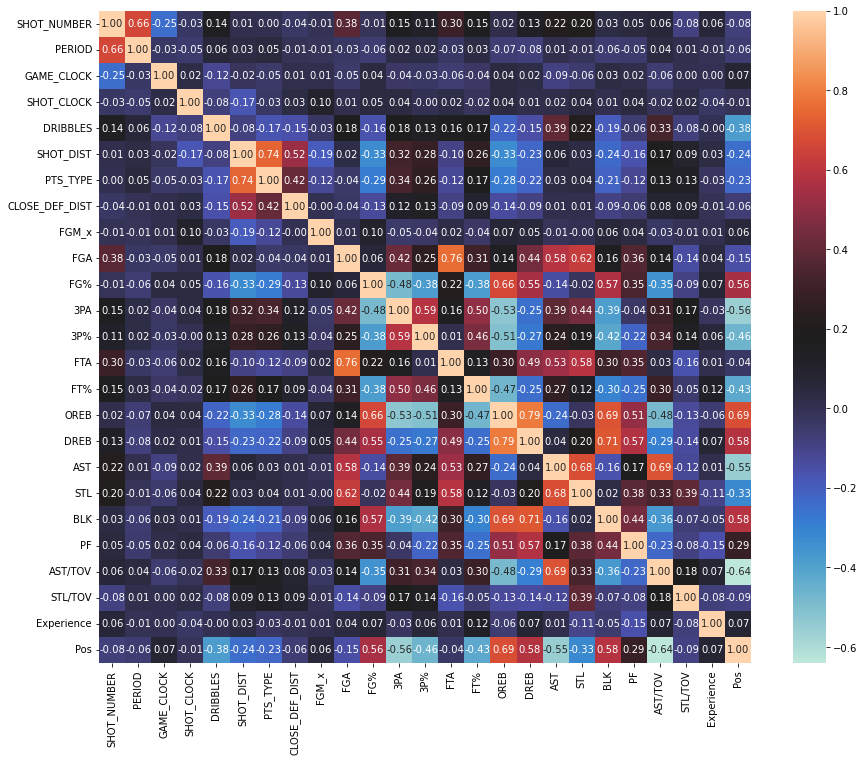

In [40]:
# feature correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(data_select.corr(), square=True, annot=True, fmt='.2f', cmap='icefire')
plt.show()

In [41]:
data_select.isna().sum()

SHOT_NUMBER          0
PERIOD               0
GAME_CLOCK           0
SHOT_CLOCK        5192
DRIBBLES             0
SHOT_DIST            0
PTS_TYPE             0
CLOSE_DEF_DIST       0
FGM_x                0
FGA                  0
FG%                  0
3PA                  0
3P%                  0
FTA                  0
FT%                  0
OREB                 0
DREB                 0
AST                  0
STL                  0
BLK                  0
PF                   0
AST/TOV              0
STL/TOV              0
Experience           0
Pos                  0
dtype: int64

In [42]:
# filling nulls using SimpleImputer
imputer = SimpleImputer()
data_imputed = imputer.fit_transform(data_select)

# scaling using MinMaxScaler
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(data_imputed)

data_prep = pd.DataFrame(data_scaled, index=data_select.index, columns=data_select.columns)
data_prep_reduced = data_prep.sample(frac = 0.1, random_state=41)
print('null in dataset : ', data_prep.isna().sum().sum())

null in dataset :  0


In [43]:
# multicollinearity check
vif_df = pd.DataFrame()
vif_df['Feature'] = data_prep.columns
vif_df['VIF'] = [variance_inflation_factor(data_prep.values, i) 
                 for i in range(len(data_prep.columns))]

vif_df.sort_values('VIF', ascending=False)

,Feature,VIF
18,STL,36.084997
9,FGA,33.695514
17,AST,32.682833
14,FT%,31.838094
21,AST/TOV,24.269446
16,DREB,22.786594
22,STL/TOV,20.173951
10,FG%,14.864614
12,3P%,14.148277
20,PF,13.334737


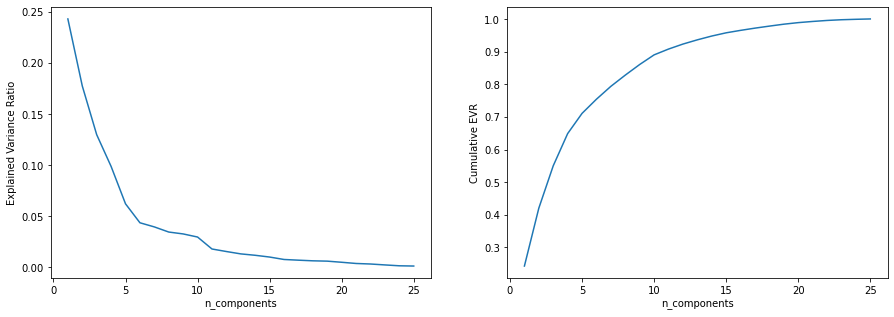

In [44]:
# PCA with all features as components
pca = PCA(n_components=25).fit(data_prep)

# explained variance ratio graph
fig,ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(range(1,26), pca.explained_variance_ratio_)
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Explained Variance Ratio')

# cumulative EVR graph
ax[1].plot(range(1,26), np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('Cumulative EVR')
plt.show()

In [45]:
# PCA with the amount of variance that needs to be explained is greater than .9
pca_prep = PCA(n_components=0.9).fit(data_prep)

# estimated number of components to keep
pca_prep.n_components_

11

In [46]:
# datasets with estimated number of components
data_fix = pca_prep.transform(data_prep)
data_fix_reduced = pca_prep.transform(data_prep_reduced)

## Model Definition

In [47]:
kmeans = [KMeans(n_clusters=k, random_state=41).fit(data_fix) for k in range(2, 11)]
dbscan = DBSCAN(eps=0.6, n_jobs=-1)
sc = SpectralClustering(n_clusters=4, gamma=10, random_state=41, n_jobs=-1)
agg1 = AgglomerativeClustering(n_clusters=5, linkage='single')
agg2 = AgglomerativeClustering(n_clusters=6, linkage='ward')

## Model Training

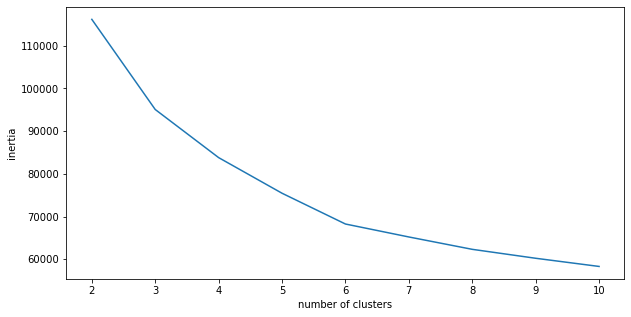

In [48]:
# sum of distances of samples to their closest cluster center (kmeans)
inertia = [model.inertia_ for model in kmeans]

# inertia vs number of clusters graph
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

In [49]:
# KMeans training
kmeans_fix = KMeans(n_clusters=6, random_state=41)
kmeans_fit = kmeans_fix.fit(data_fix)
kmeans_labels = kmeans_fit.labels_

print('kmeans label distribution')
print(np.array(np.unique(kmeans_labels, return_counts=True)).T)

kmeans label distribution
[[    0 20502]
 [    1 23940]
 [    2 19035]
 [    3 19261]
 [    4 26151]
 [    5 11107]]


In [50]:
# DBSCAN training
dbscan_fit = dbscan.fit(data_fix)
dbscan_labels = dbscan_fit.labels_

print('dbscan label distribution')
print(np.array(np.unique(dbscan_labels, return_counts=True)).T)

dbscan label distribution
[[   -1     5]
 [    0 43195]
 [    1 20535]
 [    2 45149]
 [    3 11112]]


In [51]:
# SpectralClustering training
sc_fit = sc.fit(data_fix_reduced)
sc_labels = sc_fit.labels_

print('spectral clustering label distribution')
print(np.array(np.unique(sc_labels, return_counts=True)).T)

spectral clustering label distribution
[[   0 4474]
 [   1 1149]
 [   2 4277]
 [   3 2100]]


In [52]:
# AgglomerativeClustering training (1)
agg_fit_1 = agg1.fit(data_fix_reduced)
agg_labels_1 = agg_fit_1.labels_

print('agglomerative clustering (n_clusters=5) label distribution')
print(np.array(np.unique(agg_labels_1, return_counts=True)).T)

agglomerative clustering (n_clusters=5) label distribution
[[   0 2099]
 [   1 1149]
 [   2 4277]
 [   3    1]
 [   4 4474]]


In [53]:
# AgglomerativeClustering training (2)
agg_fit_2 = agg2.fit(data_fix_reduced)
agg_labels_2 = agg_fit_2.labels_

print('agglomerative clustering (n_clusters=6) label distribution')
print(np.array(np.unique(agg_labels_2, return_counts=True)).T)

agglomerative clustering (n_clusters=6) label distribution
[[   0 2238]
 [   1 2956]
 [   2 2944]
 [   3 1321]
 [   4 1530]
 [   5 1011]]


In [54]:
# print('silhouette score')
# print('kmeans :', silhouette_score(data_fix, kmeans_labels))
# print('dbscan :', silhouette_score(data_fix, dbscan_labels))
# print('spctrl :', silhouette_score(data_fix_reduced, sc_labels))
# print('agglo1 :', silhouette_score(data_fix_reduced, agg_labels_1))
# print('agglo2 :', silhouette_score(data_fix_reduced, agg_labels_2))

In [55]:
# PCA for cluster distribution plots
pca_plot = PCA(n_components=2)

pca_plot_data = pca_plot.fit_transform(data_prep)
pca_plot_df = pd.DataFrame.from_records(data=pca_plot_data, columns=['x1','x2'])
pca_plot_df['kmeans_cluster'] = kmeans_labels + 1
pca_plot_df['dbscan_cluster'] = dbscan_labels + 1

pca_plot_data_2 = pca_plot.fit_transform(data_prep_reduced)
pca_plot_df2 = pd.DataFrame.from_records(data=pca_plot_data_2, columns=['x1','x2'])
pca_plot_df2['sc_cluster'] = sc_labels + 1
pca_plot_df2['agg1_cluster'] = agg_labels_1 + 1
pca_plot_df2['agg2_cluster'] = agg_labels_2 + 1

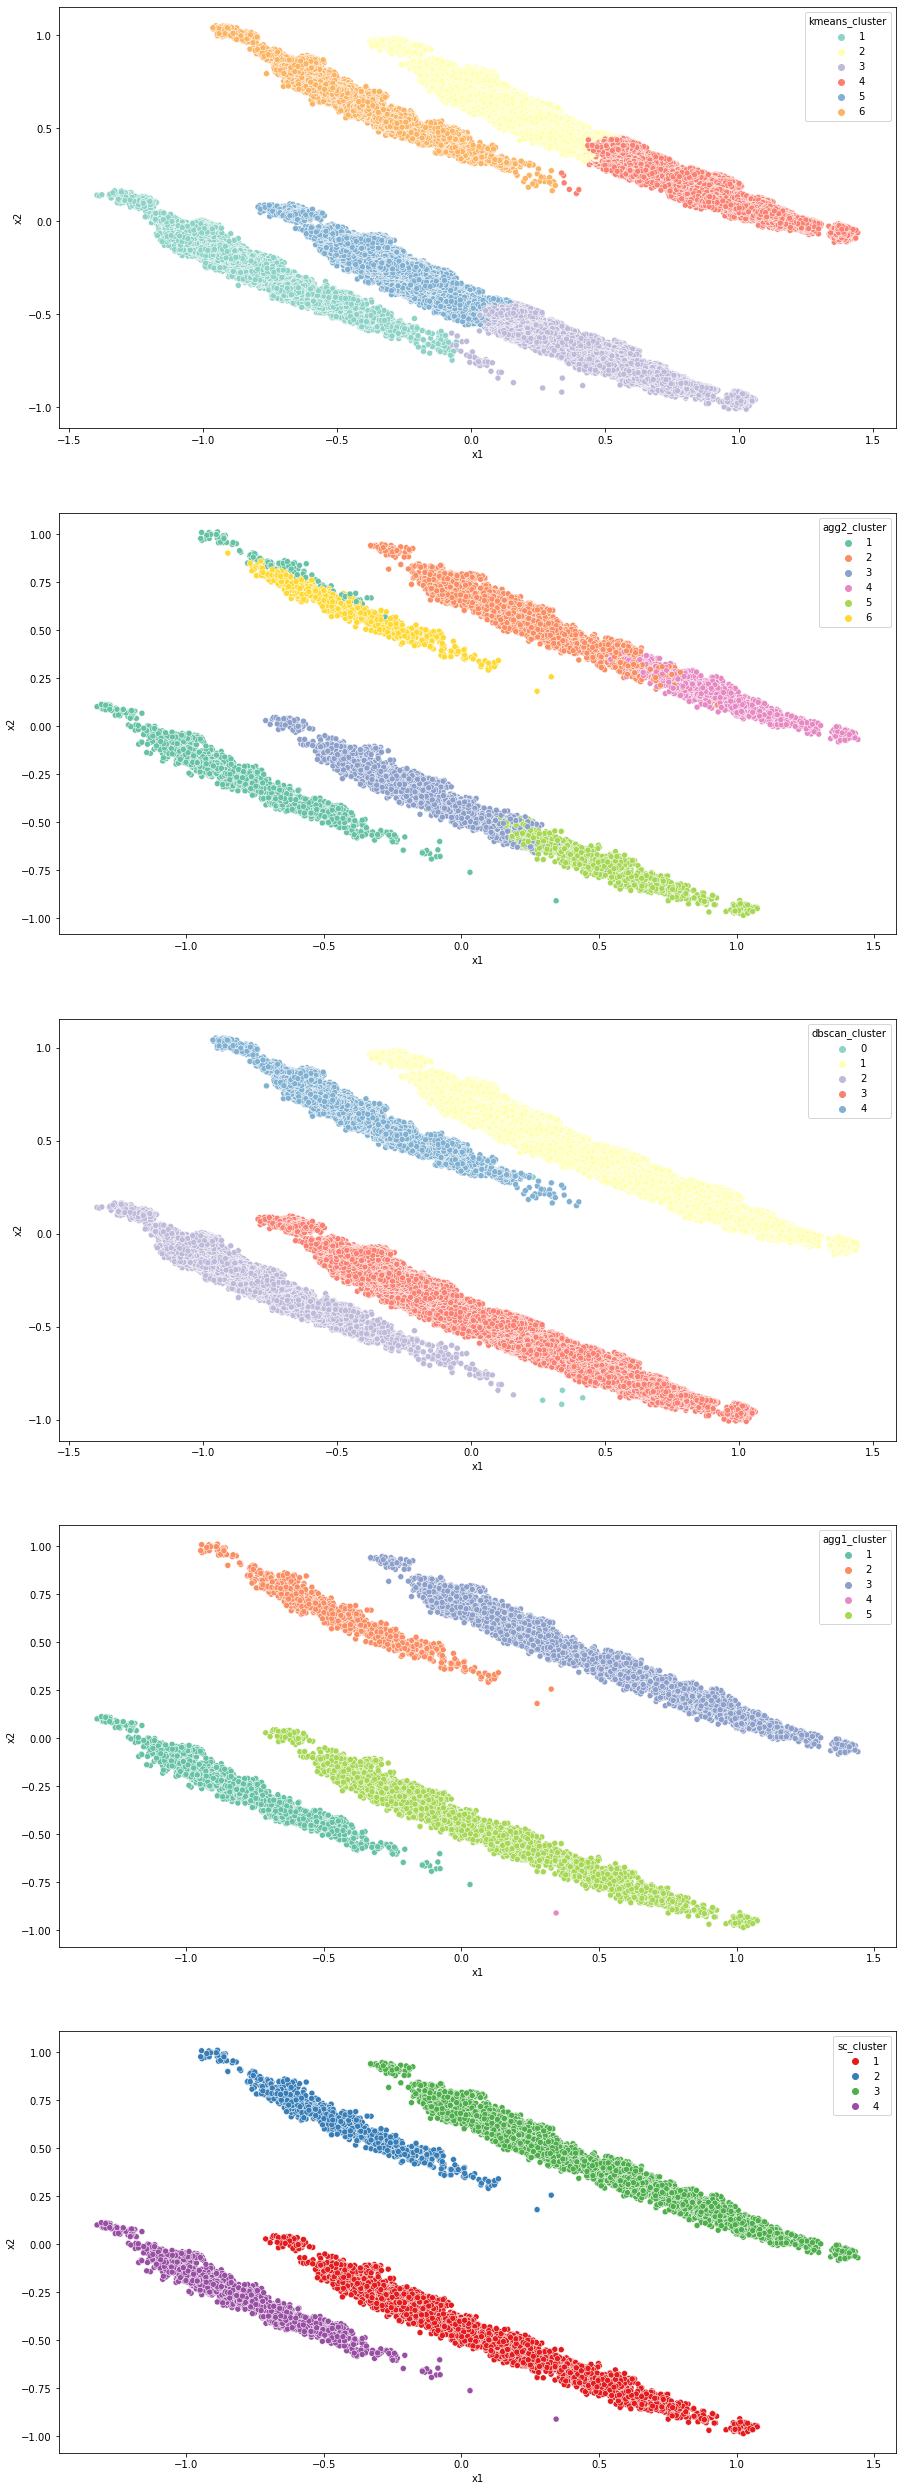

In [56]:
# cluster distribution plots
plt.figure(figsize=(15, 45))

plt.subplot(5, 1, 1)
sns.scatterplot(x='x1', y='x2', hue='kmeans_cluster', data=pca_plot_df, palette='Set3')

plt.subplot(5, 1, 2)
sns.scatterplot(x='x1', y='x2', hue='agg2_cluster', data=pca_plot_df2, palette='Set2')

plt.subplot(5, 1, 3)
sns.scatterplot(x='x1', y='x2', hue='dbscan_cluster', data=pca_plot_df, palette='Set3')

plt.subplot(5, 1, 4)
sns.scatterplot(x='x1', y='x2', hue='agg1_cluster', data=pca_plot_df2, palette='Set2')

plt.subplot(5, 1, 5)
sns.scatterplot(x='x1', y='x2', hue='sc_cluster', data=pca_plot_df2, palette='Set1')

plt.show()

## Model Evaluation

In [57]:
dict_cluster_reduced = {'sc_cluster': sc_labels + 1, 'agg1_cluster': agg_labels_1 + 1,
                        'agg2_cluster': agg_labels_2 + 1}
data_cluster_reduced = pd.DataFrame(dict_cluster_reduced, index=data_prep_reduced.index)

data['kmeans_cluster'] = kmeans_labels + 1
data['dbscan_cluster'] = dbscan_labels + 1
data = pd.concat([data, data_cluster_reduced], axis=1)

data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,Height,Pos,Team,Weight,BMI,kmeans_cluster,dbscan_cluster,sc_cluster,agg1_cluster,agg2_cluster
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,69.0,10.8,2,...,182.5,1.0,CHA,77.85,23.373991,2,1,NaN,NaN,NaN
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,14.0,3.4,0,...,182.5,1.0,CHA,77.85,23.373991,1,2,NaN,NaN,NaN
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0.0,NaN,3,...,182.5,1.0,CHA,77.85,23.373991,5,3,NaN,NaN,NaN
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,707.0,10.3,2,...,182.5,1.0,CHA,77.85,23.373991,5,3,NaN,NaN,NaN
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,634.0,10.9,2,...,182.5,1.0,CHA,77.85,23.373991,5,3,NaN,NaN,NaN


In [58]:
print('KMeans to Agg2 Cluster Comparison')
print('')
for x in np.linspace(1, 6, 6):
    print('KMeans Cluster =', x)
    print(data[data.kmeans_cluster == x]['agg2_cluster'].value_counts().sort_index())
    print('')

KMeans to Agg2 Cluster Comparison

KMeans Cluster = 1.0
1.0    2097
Name: agg2_cluster, dtype: int64

KMeans Cluster = 2.0
2.0    2420
Name: agg2_cluster, dtype: int64

KMeans Cluster = 3.0
1.0       3
3.0     383
5.0    1526
Name: agg2_cluster, dtype: int64

KMeans Cluster = 4.0
2.0     536
4.0    1321
6.0       1
Name: agg2_cluster, dtype: int64

KMeans Cluster = 5.0
3.0    2561
5.0       4
Name: agg2_cluster, dtype: int64

KMeans Cluster = 6.0
1.0     138
6.0    1010
Name: agg2_cluster, dtype: int64



The kmeans clusters don't really correspondent one-on-one with agg2 clusters, but in general quite similar.

In [59]:
print('DBSCAN to Spectral, Agg1 Cluster Comparison')
print('')
for x in np.linspace(0, 4, 5):
    print('DBSCAN Cluster =', x)
    print(data[data.dbscan_cluster == x][['sc_cluster', 'agg1_cluster']].value_counts().sort_index())
    print('')

DBSCAN to Spectral, Agg1 Cluster Comparison

DBSCAN Cluster = 0.0
sc_cluster  agg1_cluster
4.0         4.0             1
dtype: int64

DBSCAN Cluster = 1.0
sc_cluster  agg1_cluster
3.0         3.0             4277
dtype: int64

DBSCAN Cluster = 2.0
sc_cluster  agg1_cluster
4.0         1.0             2099
dtype: int64

DBSCAN Cluster = 3.0
sc_cluster  agg1_cluster
1.0         5.0             4474
dtype: int64

DBSCAN Cluster = 4.0
sc_cluster  agg1_cluster
2.0         2.0             1149
dtype: int64



the 4-clusters models correspond to each other perfectly.

In [60]:
data.query("dbscan_cluster == 0")['player_name'].value_counts().head()

deandre jordan    3
anthony davis     1
andre drummond    1
Name: player_name, dtype: int64

These data most likely are outliers.

In [61]:
data.query("kmeans_cluster == 3")['player_name'].value_counts().head()

lamarcus aldridge    535
blake griffin        433
nikola vucevic       422
demarcus cousins     422
al jefferson         417
Name: player_name, dtype: int64

In [62]:
data.query("kmeans_cluster == 4")['player_name'].value_counts().head()

nikola vucevic       478
anthony davis        456
lamarcus aldridge    448
blake griffin        439
marc gasol           403
Name: player_name, dtype: int64

These are bigger guys who shoot closer to the basket (key attribute = 'Pos', 'FG%', 'BLK'). 

In [63]:
data.query("kmeans_cluster == 2")['player_name'].value_counts().head()

monta ellis          401
lebron james         393
russell westbrook    377
tyreke evans         346
john wall            345
Name: player_name, dtype: int64

In [64]:
data.query("kmeans_cluster == 5")['player_name'].value_counts().head()

russell westbrook    430
monta ellis          420
tyreke evans         395
rudy gay             383
john wall            365
Name: player_name, dtype: int64

These are players who slash with the ball before attempting their shot (key attribute= 'DRIBBLES').

In [65]:
data.query("dbscan_cluster == 1")['player_name'].value_counts().head()

nikola vucevic       478
anthony davis        456
lamarcus aldridge    448
blake griffin        439
marc gasol           403
Name: player_name, dtype: int64

In [66]:
data.query("dbscan_cluster == 3")['player_name'].value_counts().head()

lamarcus aldridge    535
blake griffin        433
russell westbrook    430
nikola vucevic       421
demarcus cousins     421
Name: player_name, dtype: int64

These DBSCAN clusters have similar top players, players tend to attempt more 2-pointers.

In [67]:
data.query("kmeans_cluster == 6")['player_name'].value_counts().head()

stephen curry      190
klay thompson      177
kyle korver        176
wesley matthews    173
james harden       155
Name: player_name, dtype: int64

In [68]:
data.query("dbscan_cluster == 4")['player_name'].value_counts().head()

stephen curry      190
klay thompson      177
kyle korver        176
wesley matthews    173
james harden       155
Name: player_name, dtype: int64

In [69]:
data.query("kmeans_cluster == 1")['player_name'].value_counts().head()

trevor ariza       281
damian lillard     280
wesley matthews    270
stephen curry      266
james harden       251
Name: player_name, dtype: int64

In [70]:
data.query("dbscan_cluster == 2")['player_name'].value_counts().head()

trevor ariza       281
damian lillard     280
wesley matthews    270
stephen curry      266
james harden       251
Name: player_name, dtype: int64

These players are sharpshooters, who shoots a lot from outside the 3PT line (key attribute = 'SHOT_DIST', 'PTS_TYPE').

In [71]:
# cluster comparison plots
def comp_plots(df, cluster, col):
    comp_df = pd.DataFrame({'median' : df.groupby(cluster)[col].median()}).reset_index()
    
    plt.figure(figsize=(15, 5))    
    plt.title(col)
    sns.barplot(x='median', y=cluster, orient='h', data=comp_df, palette='Set1')  
    plt.show()

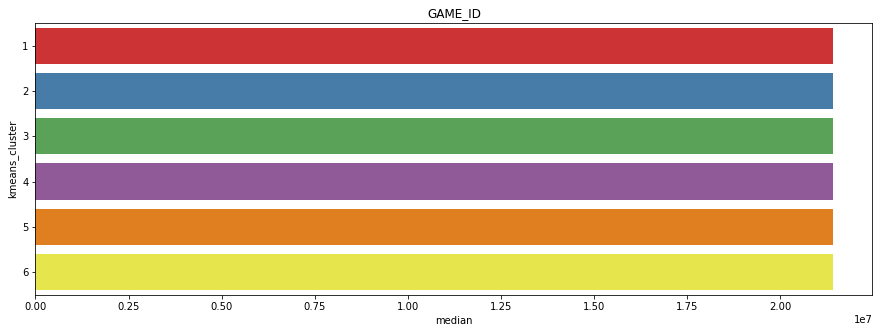

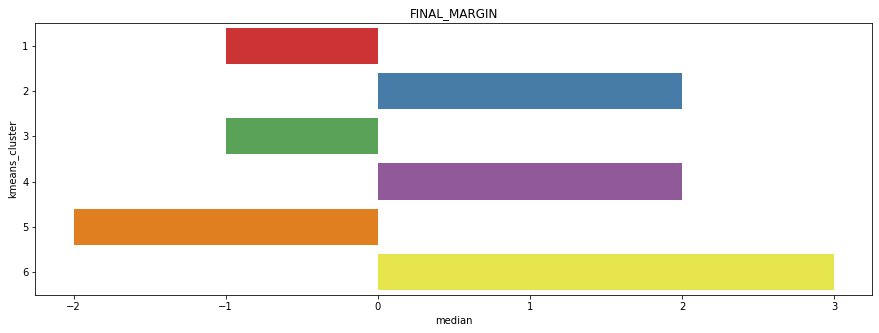

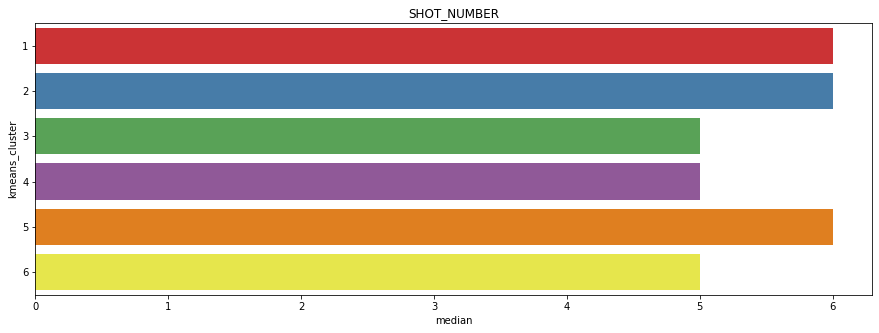

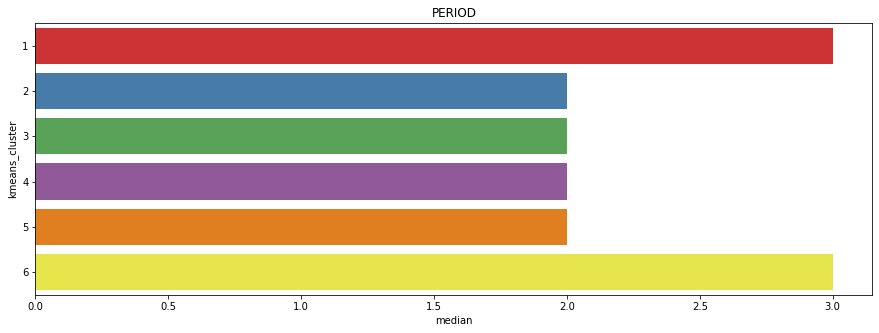

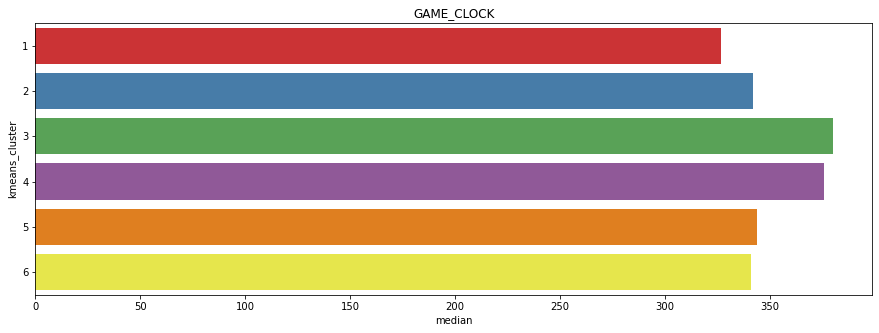

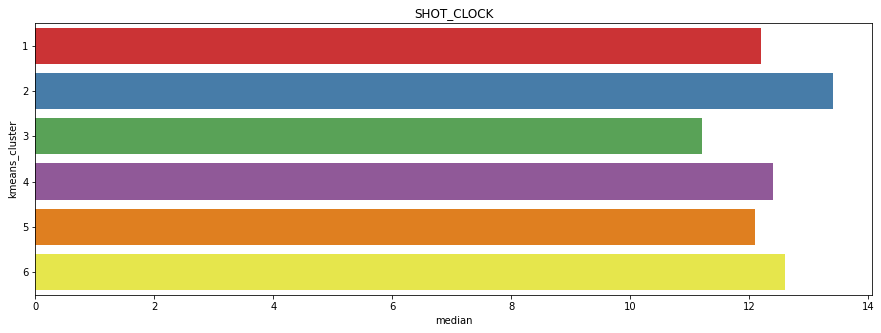

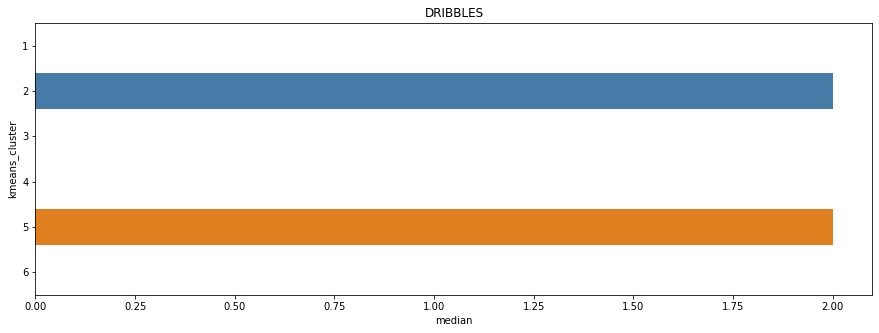

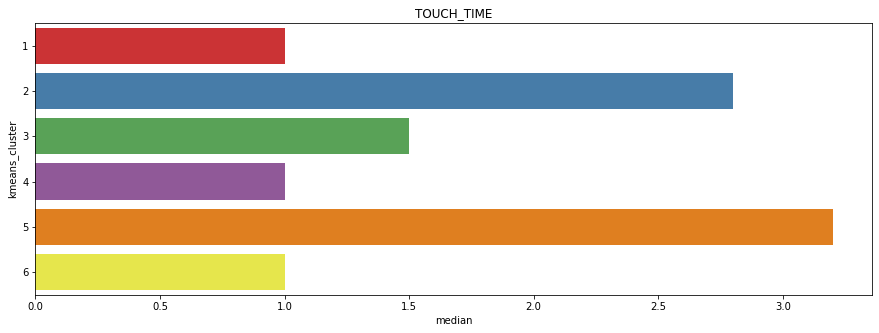

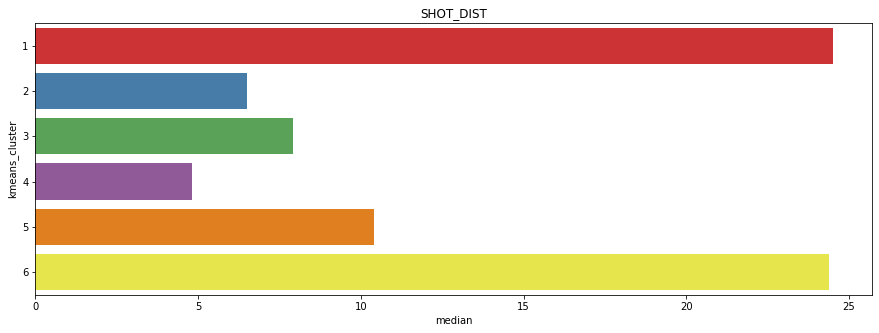

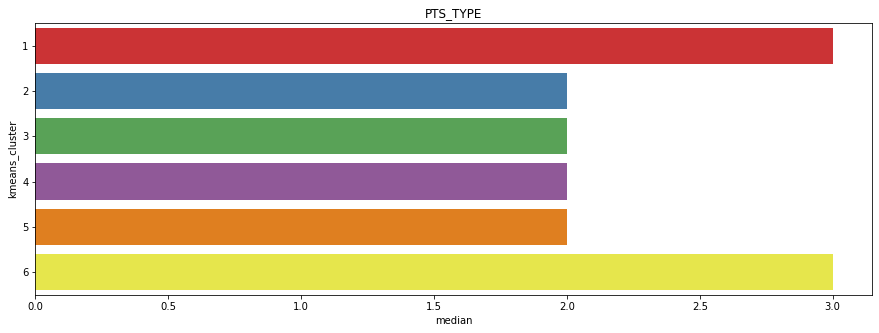

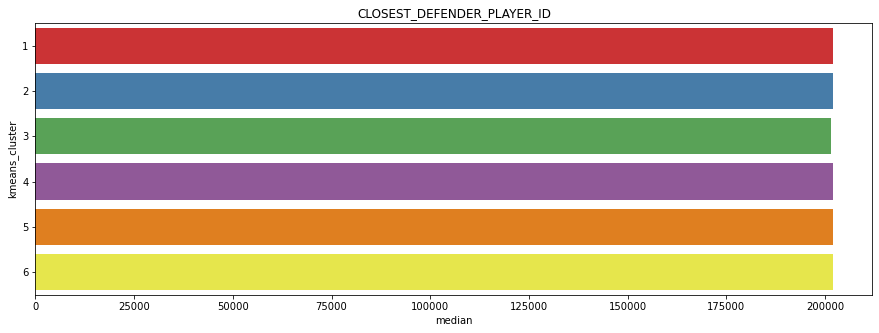

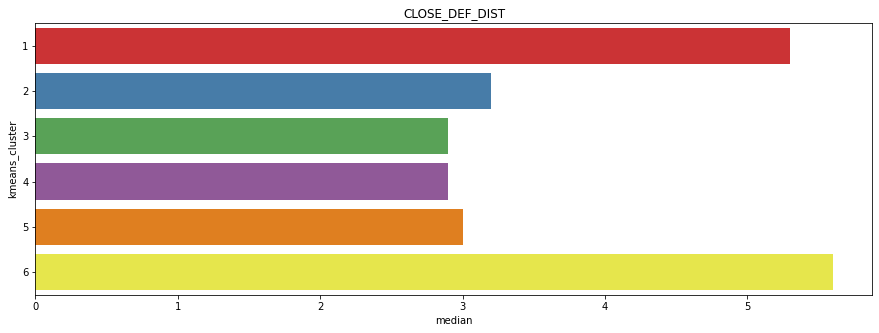

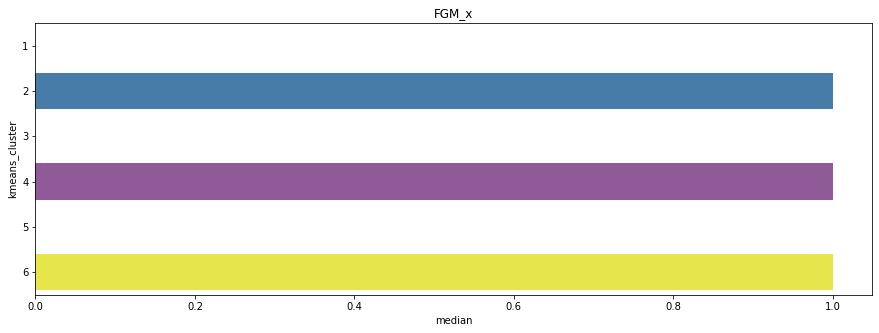

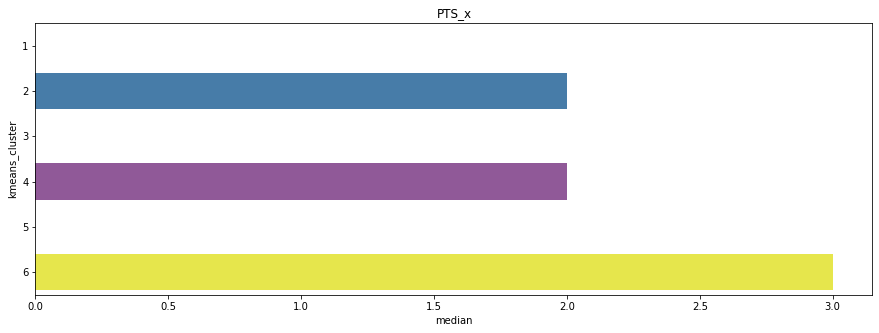

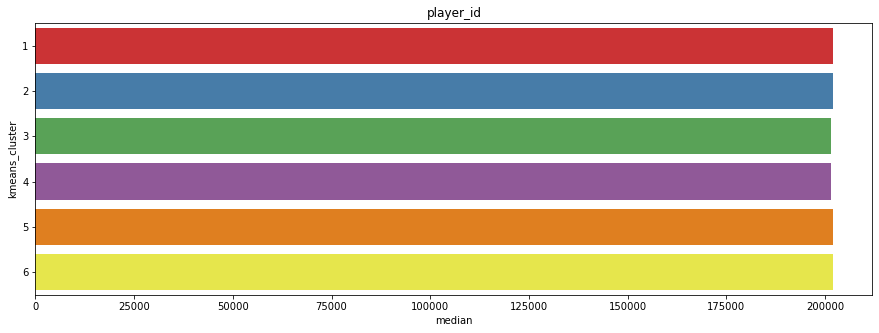

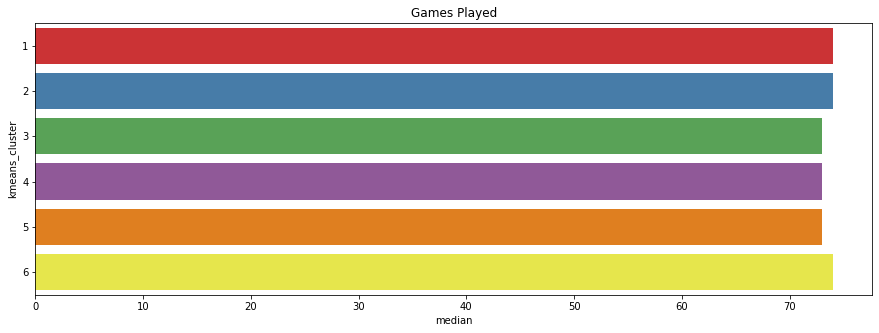

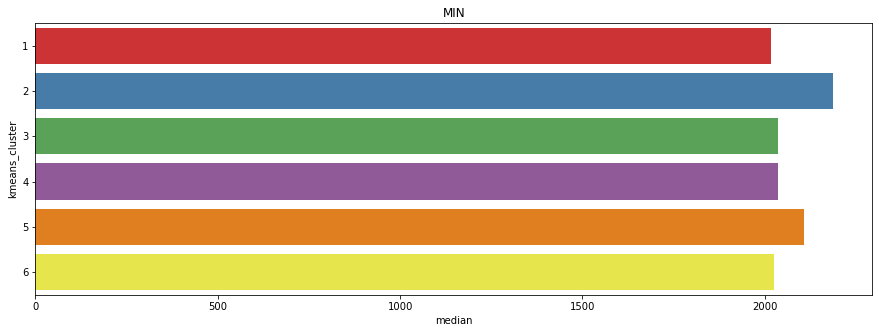

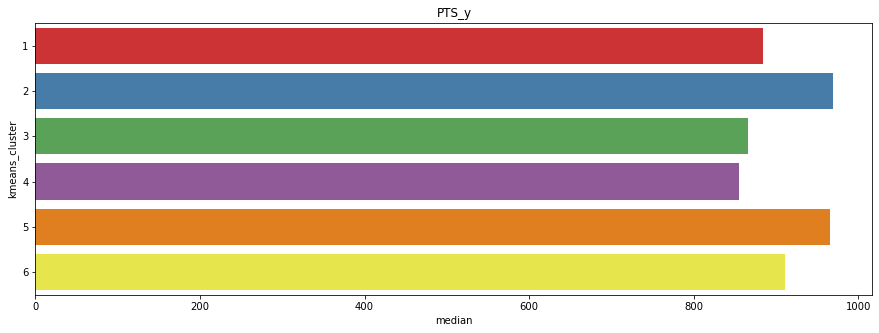

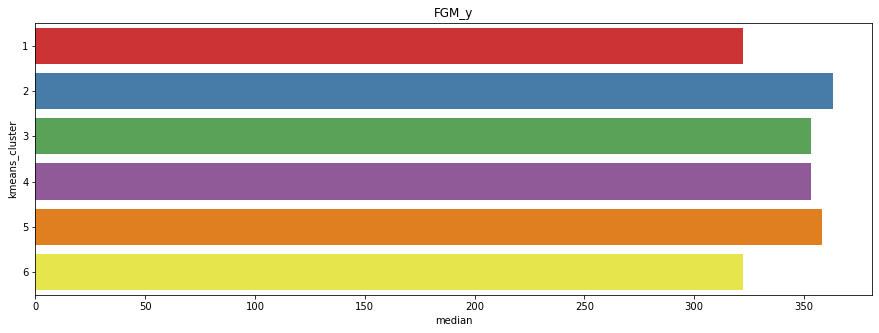

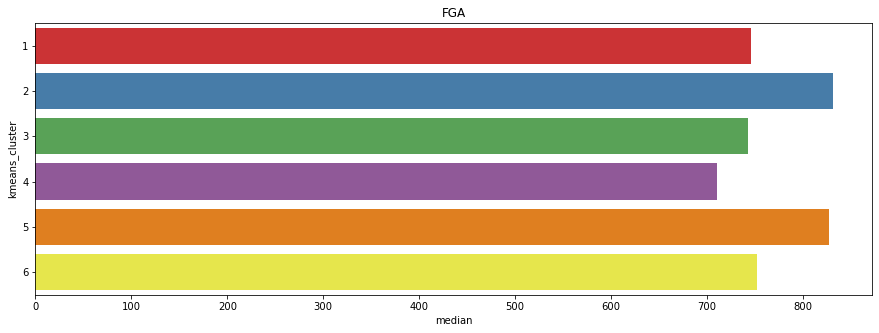

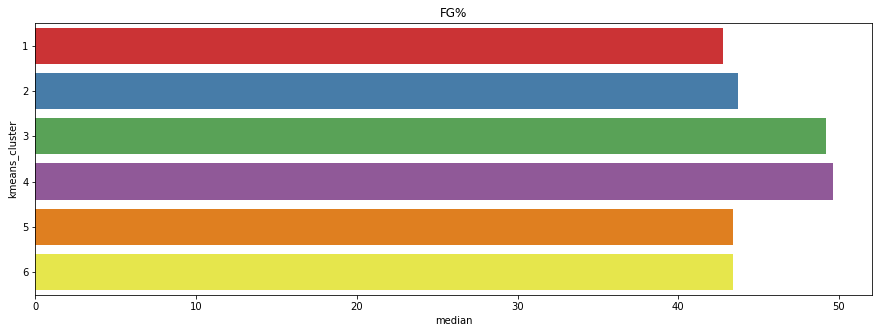

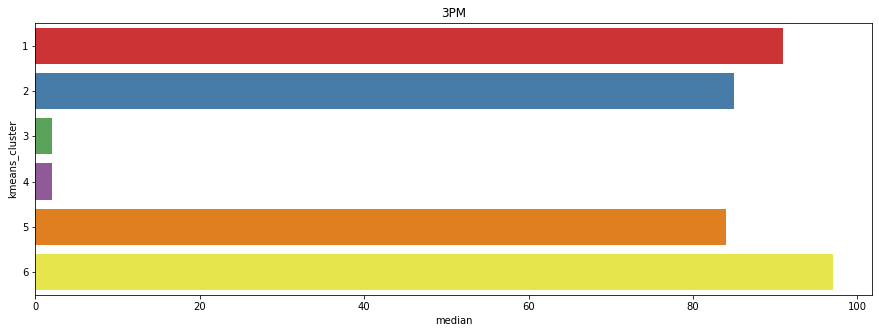

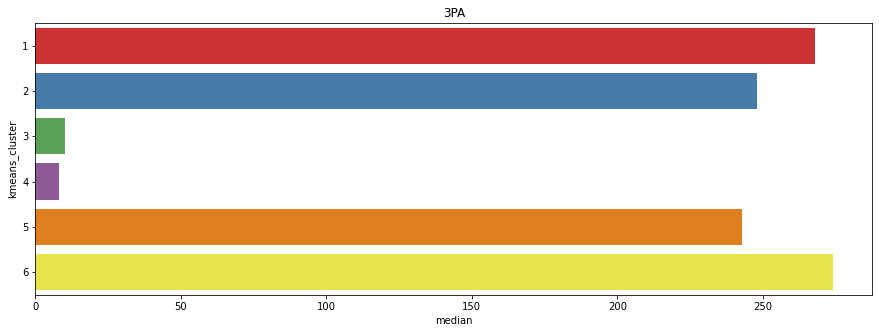

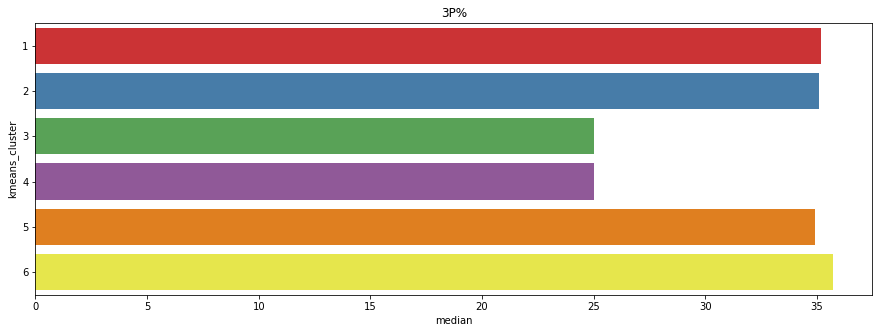

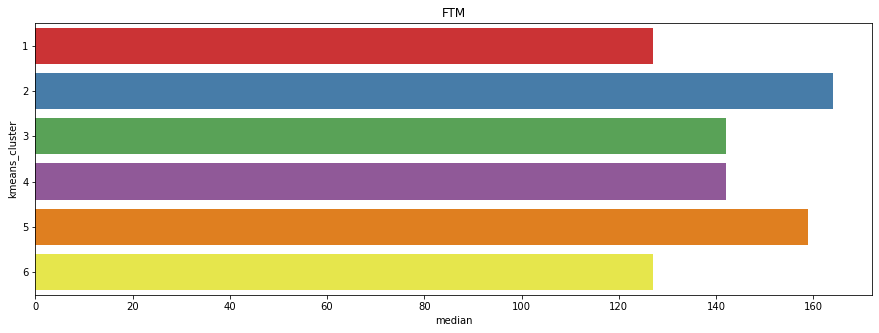

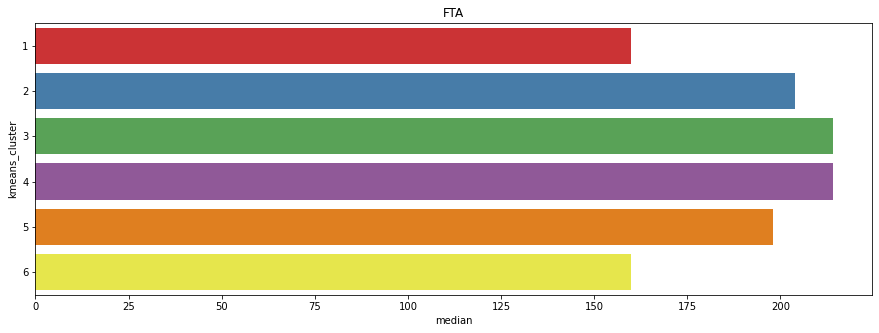

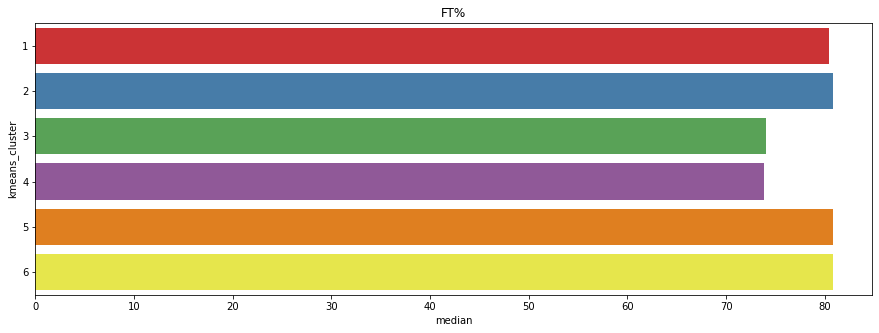

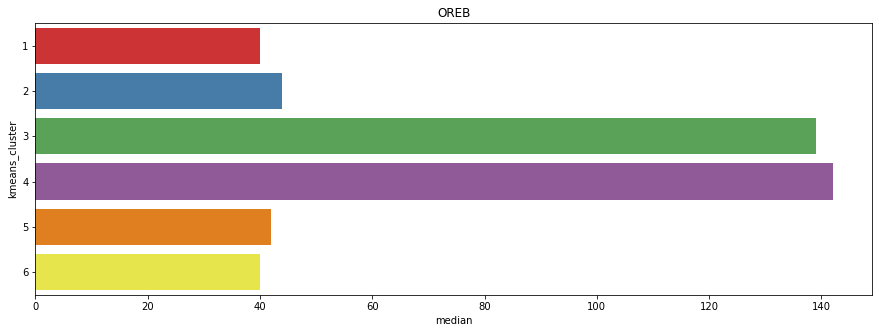

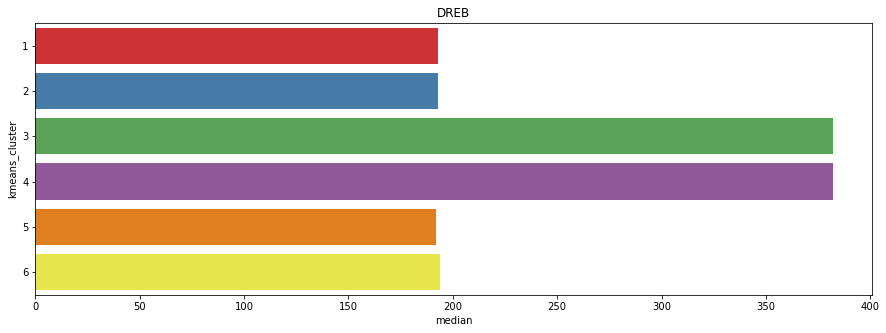

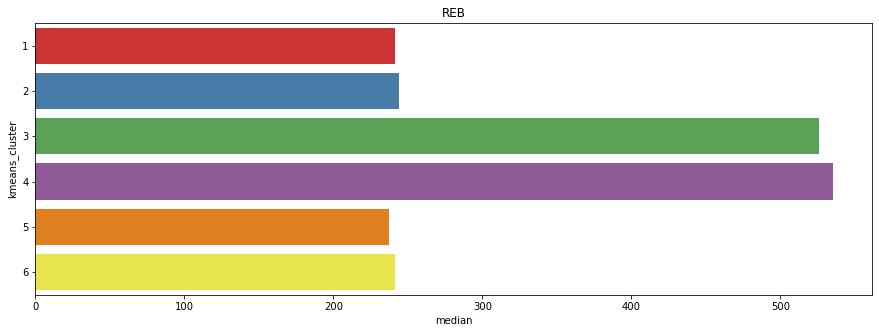

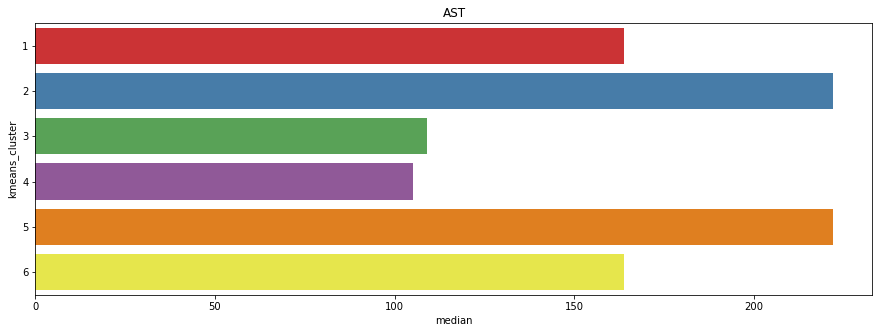

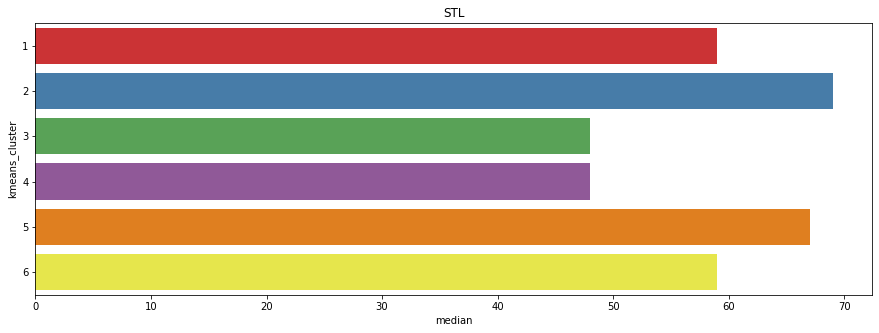

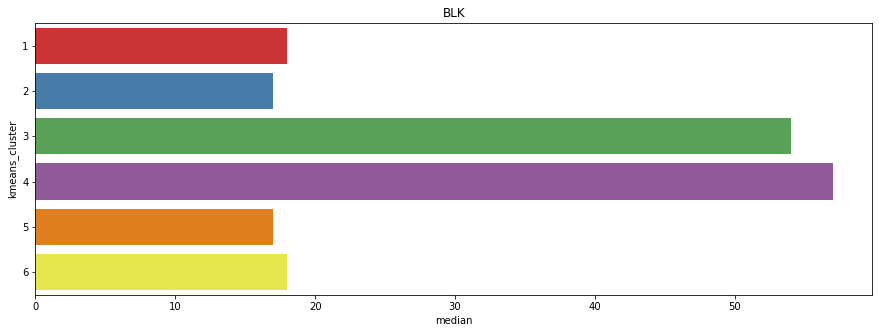

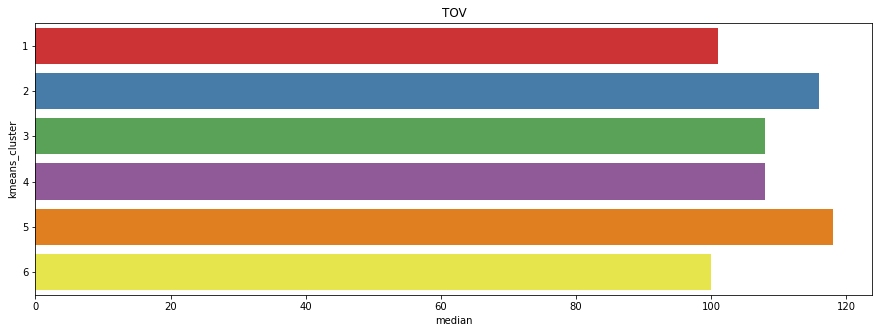

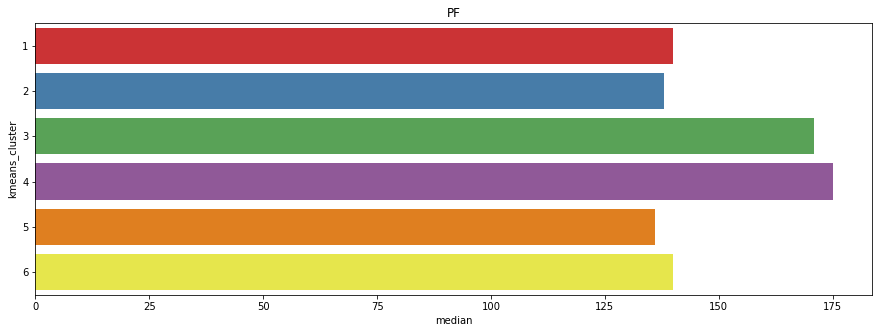

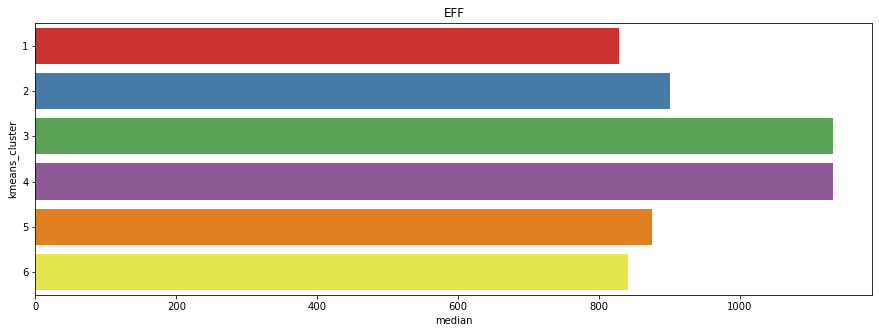

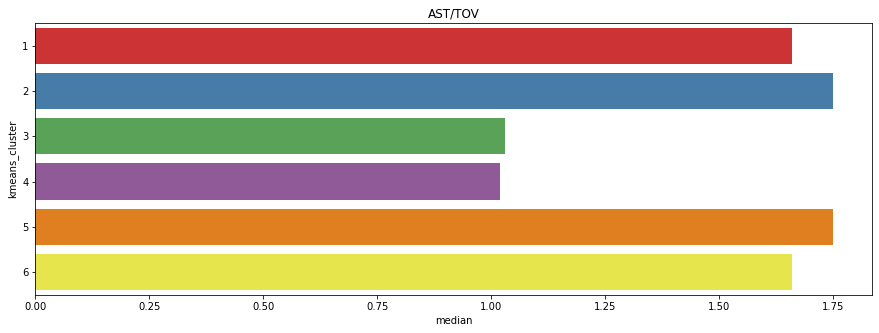

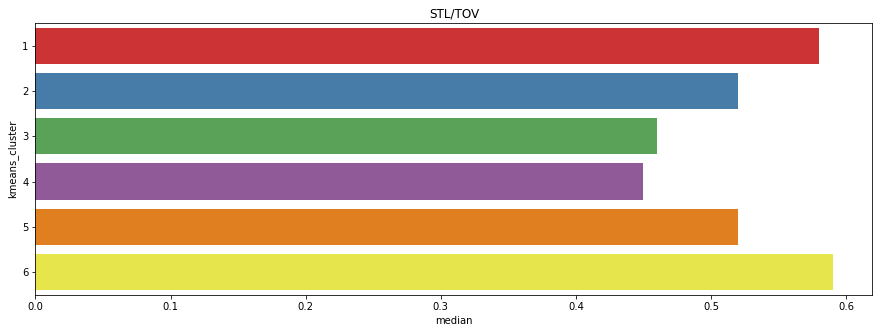

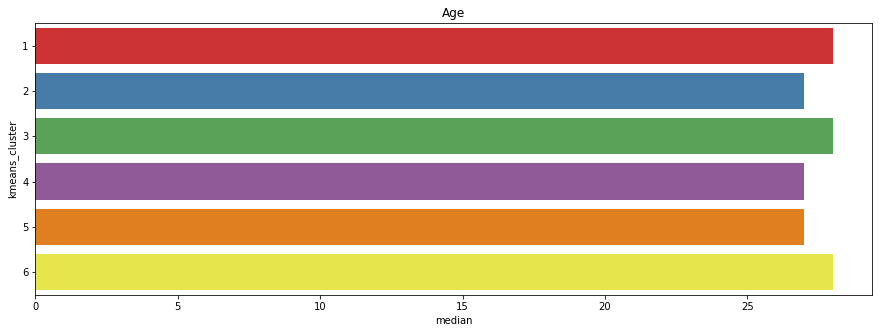

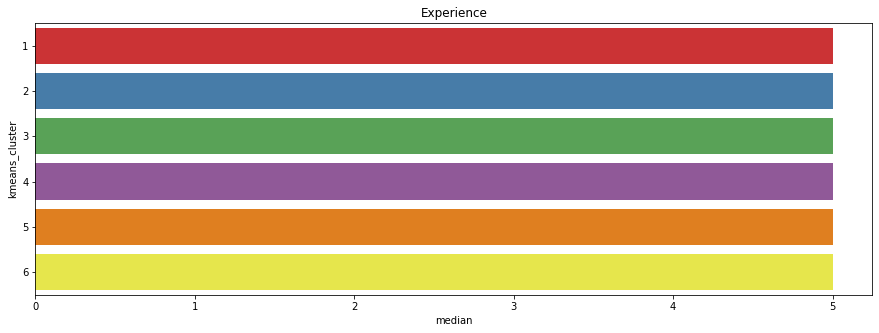

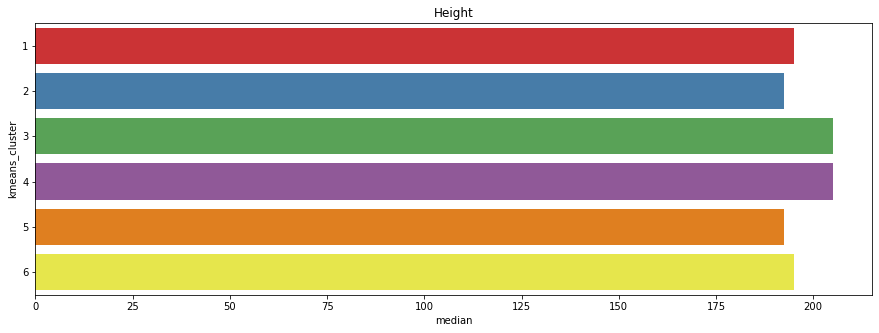

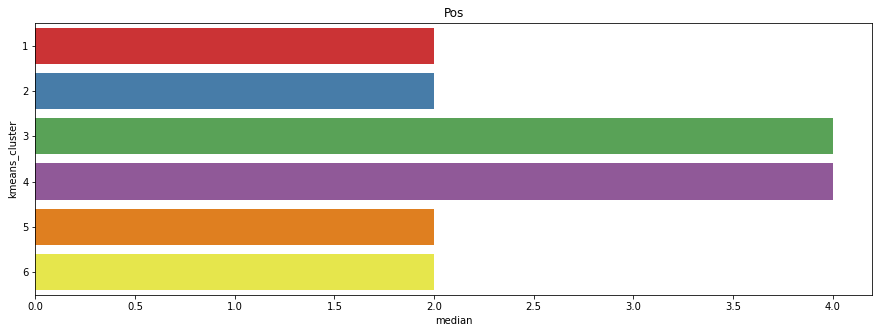

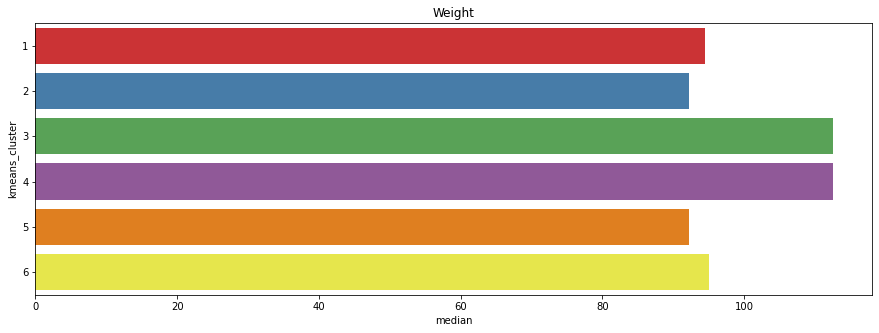

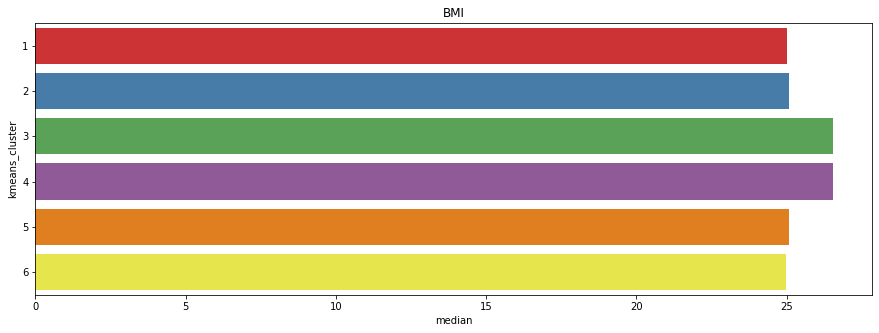

In [72]:
# comp_plots of num_col
for col in num_col:
    comp_plots(data, 'kmeans_cluster', col)

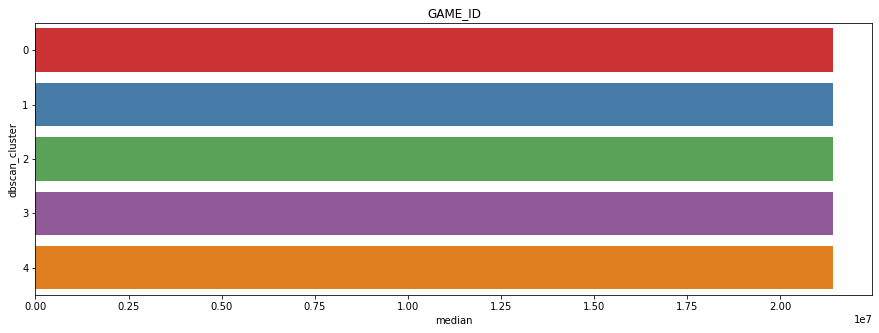

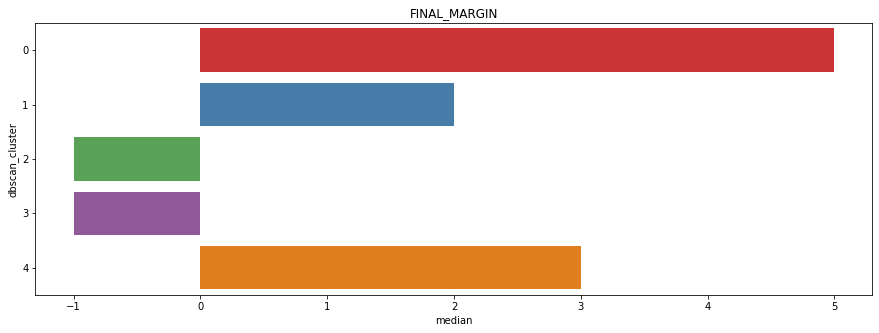

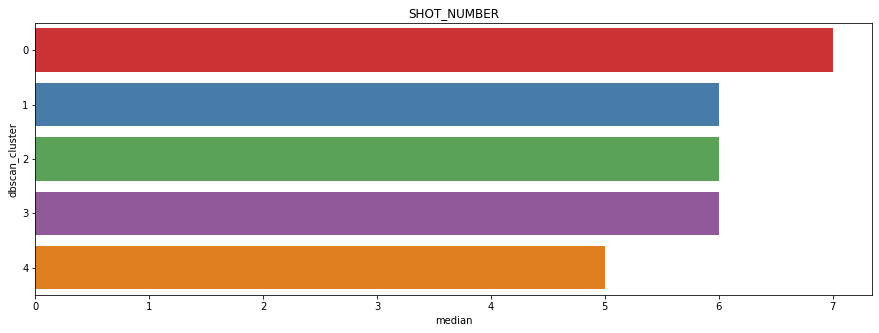

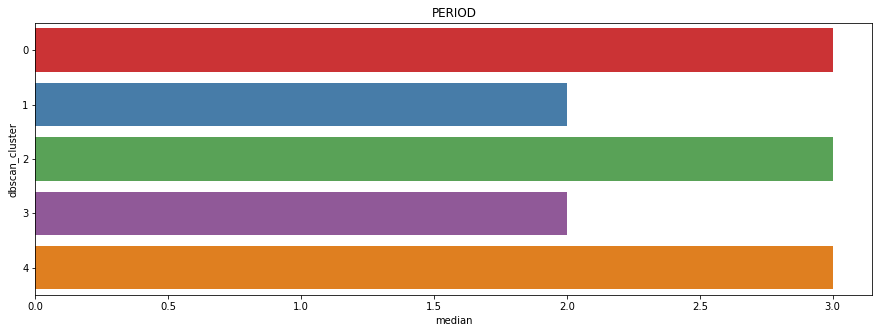

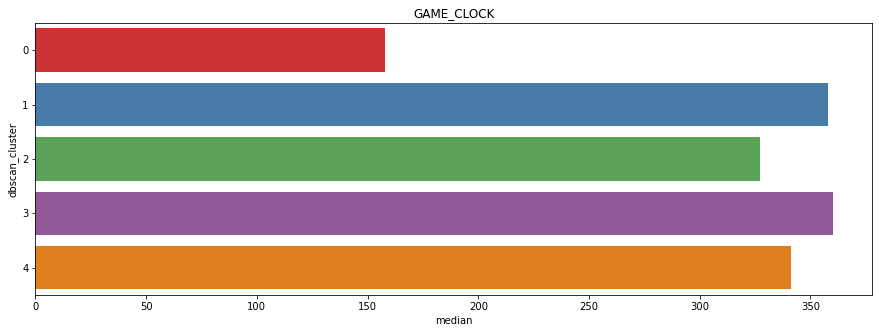

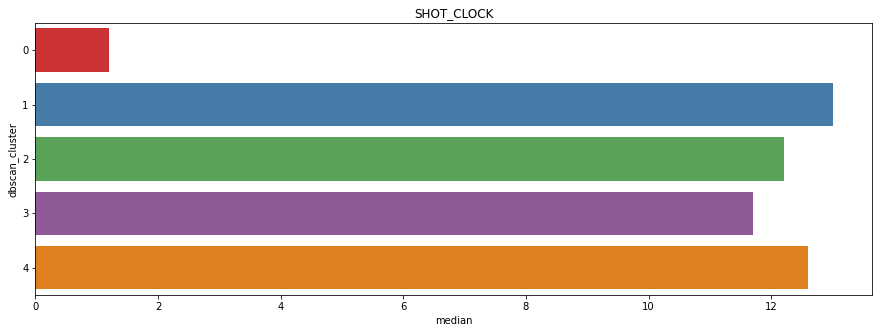

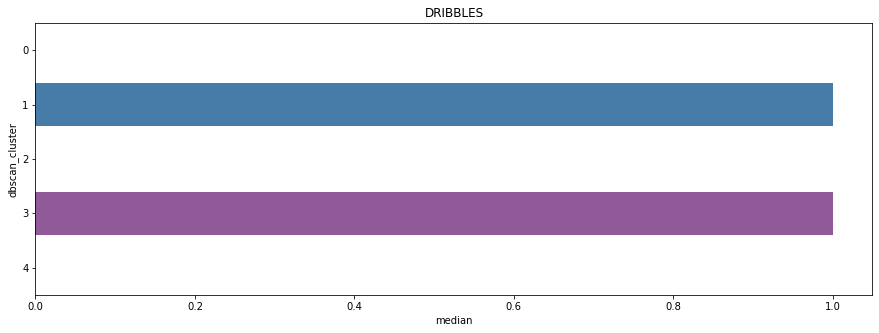

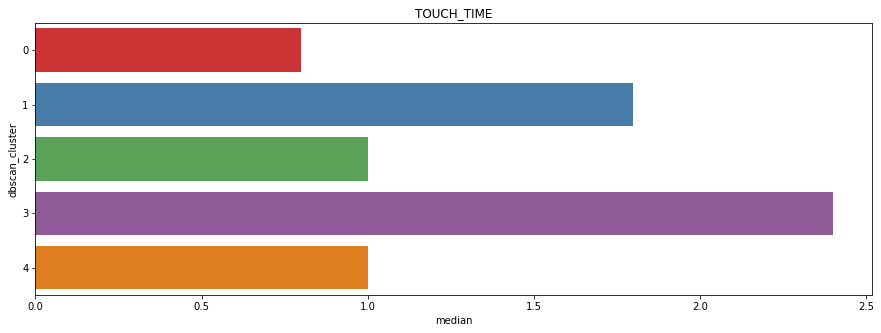

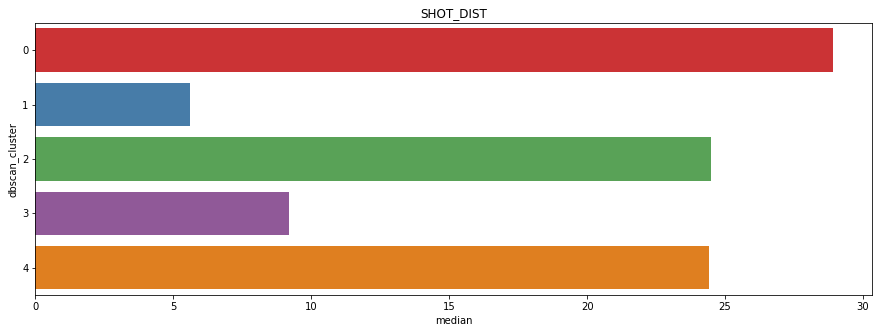

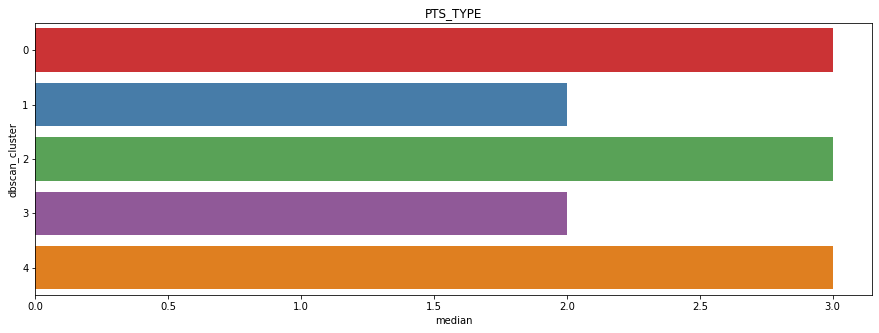

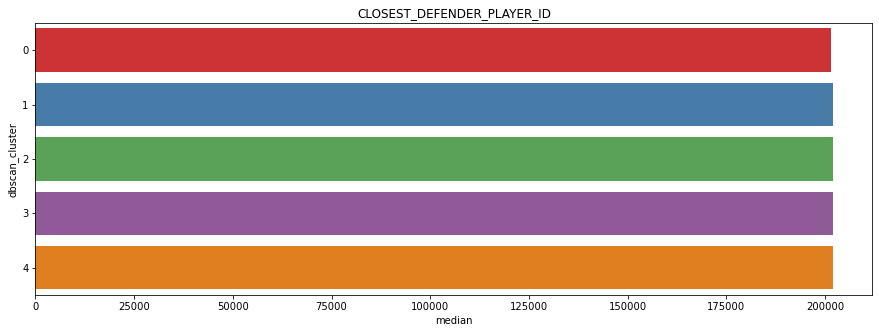

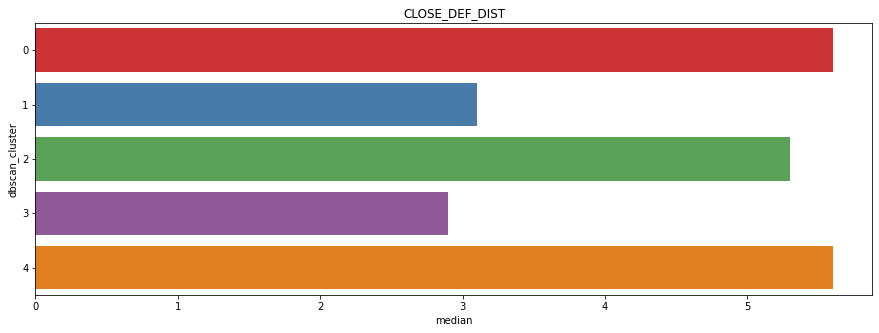

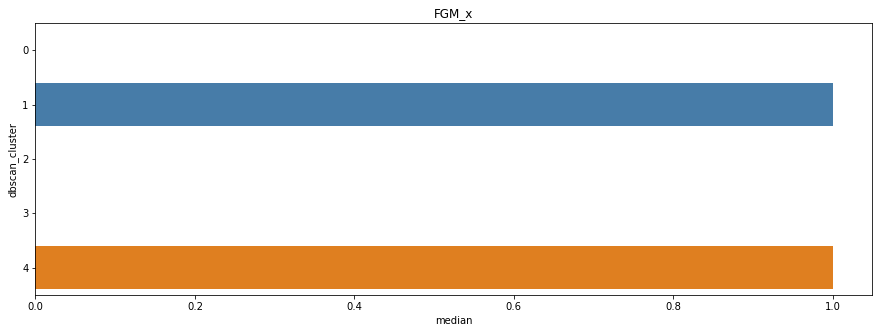

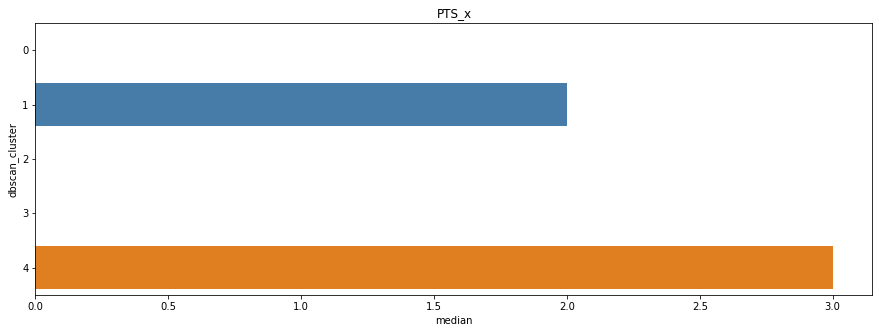

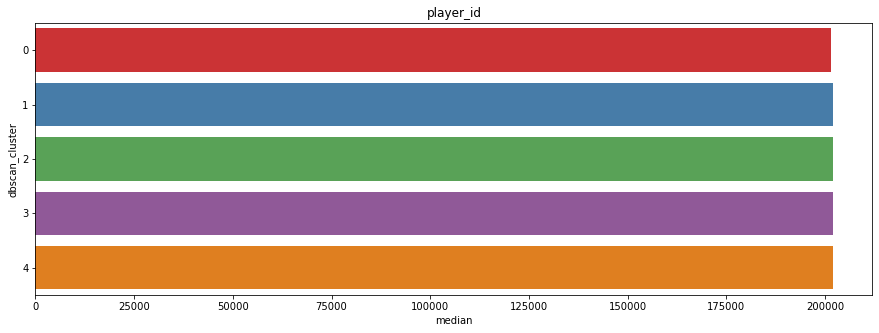

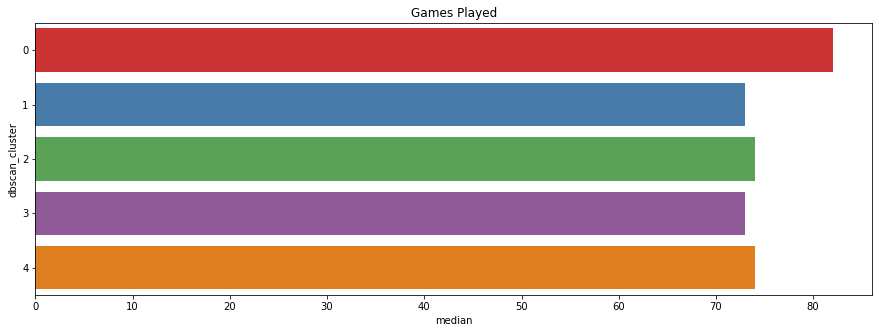

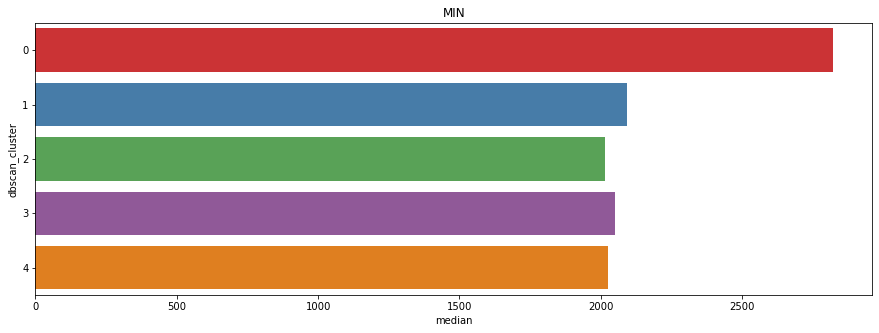

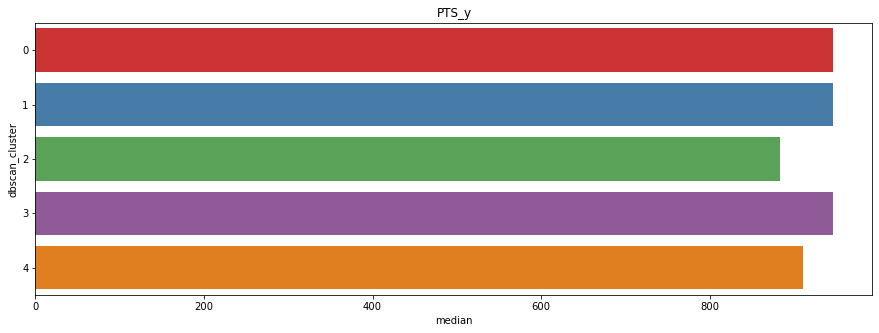

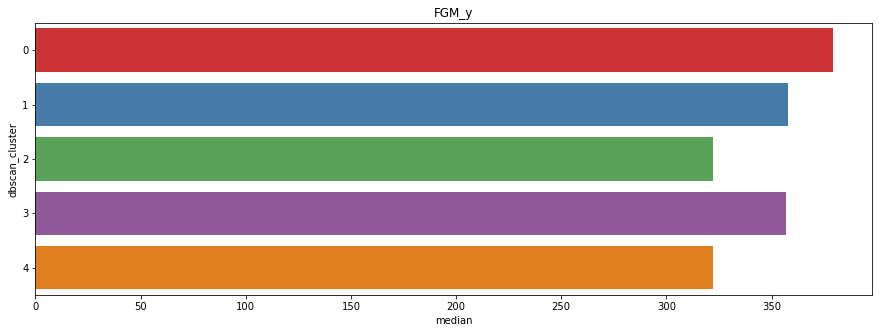

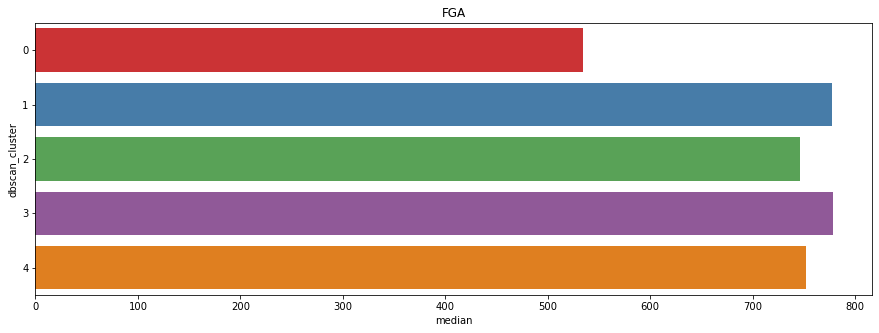

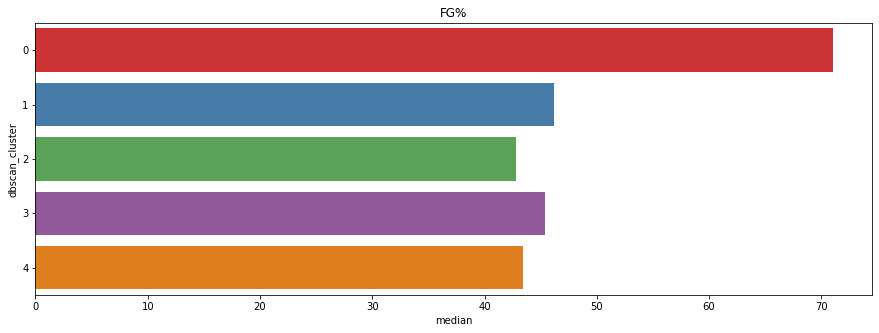

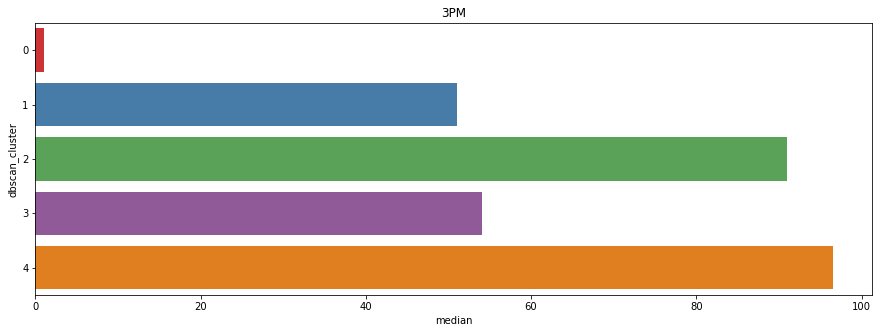

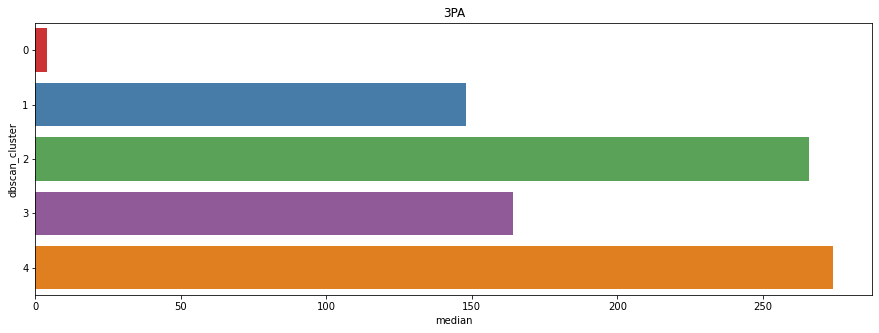

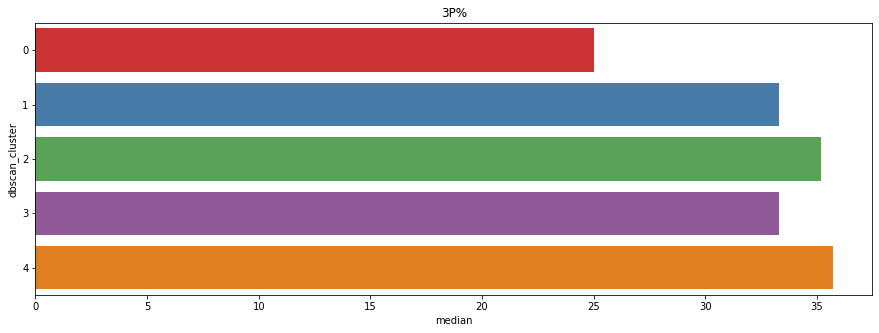

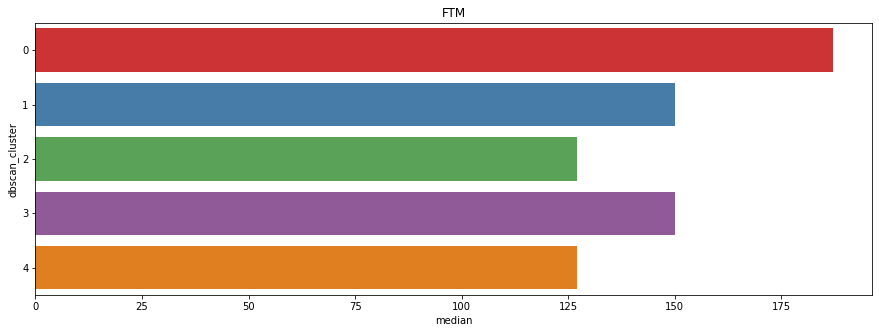

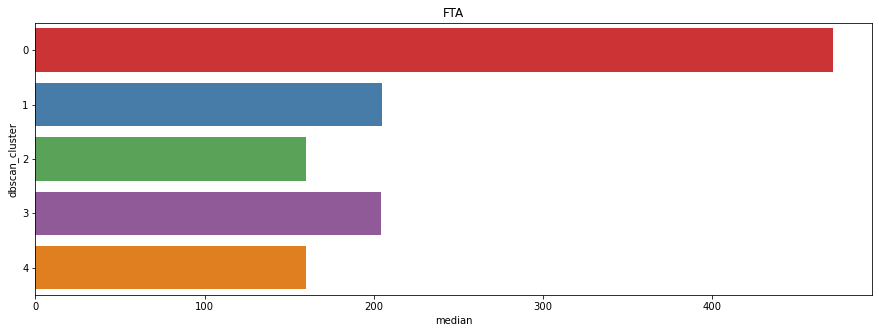

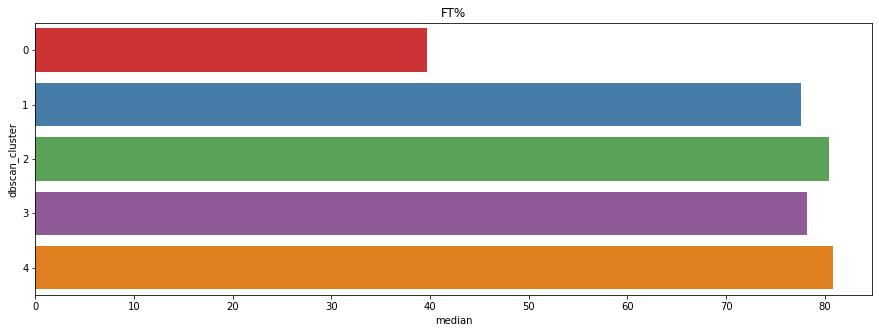

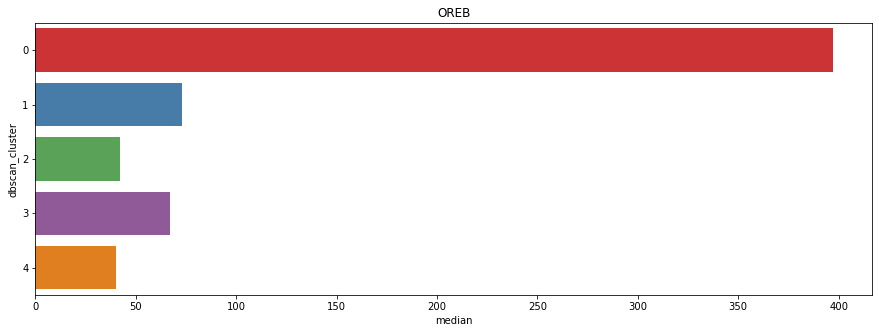

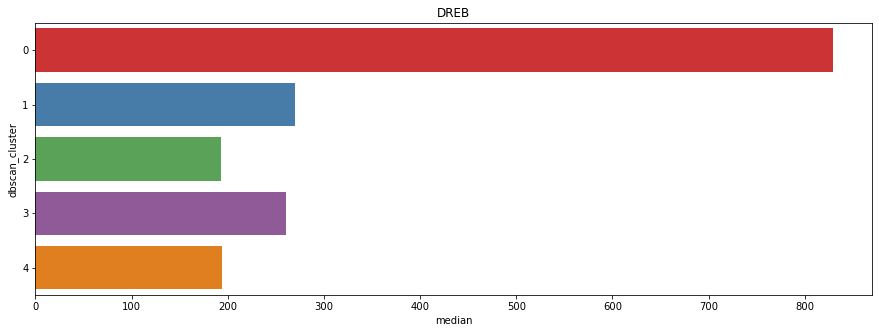

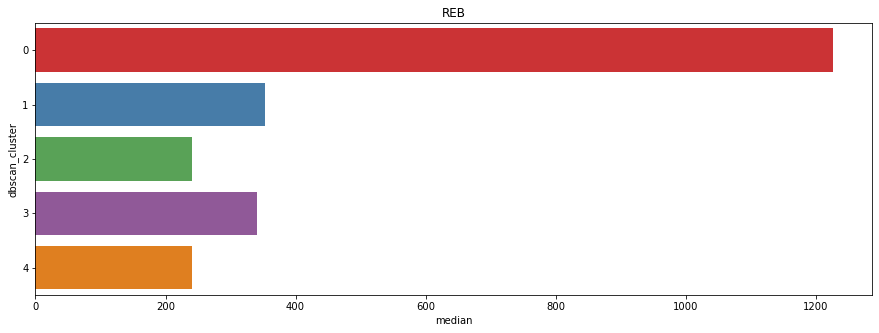

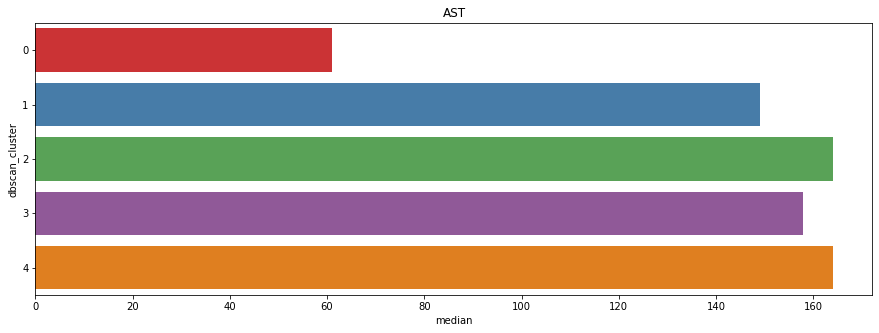

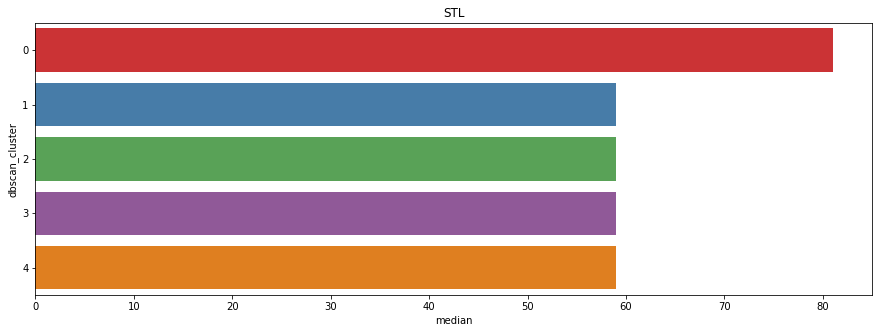

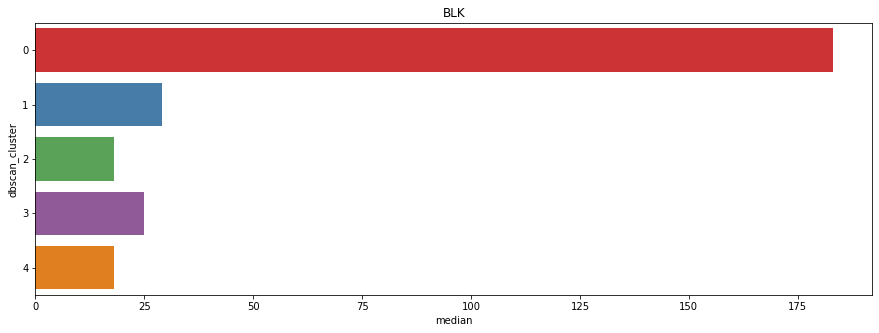

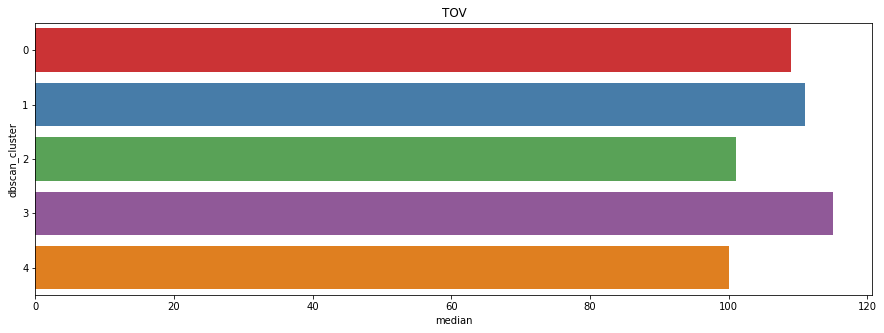

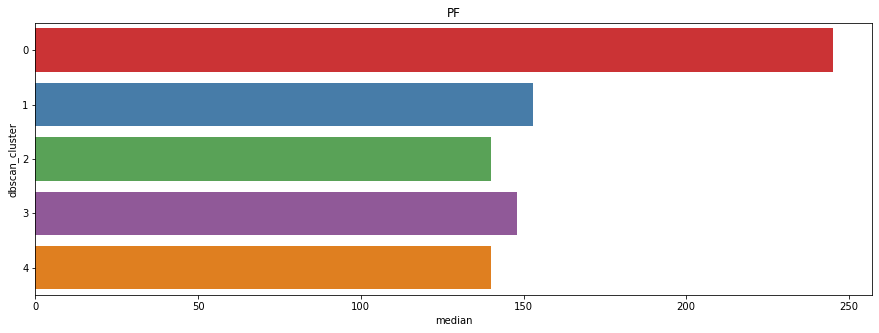

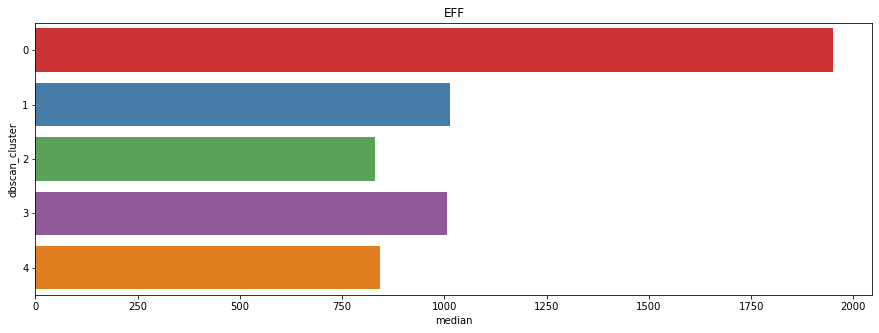

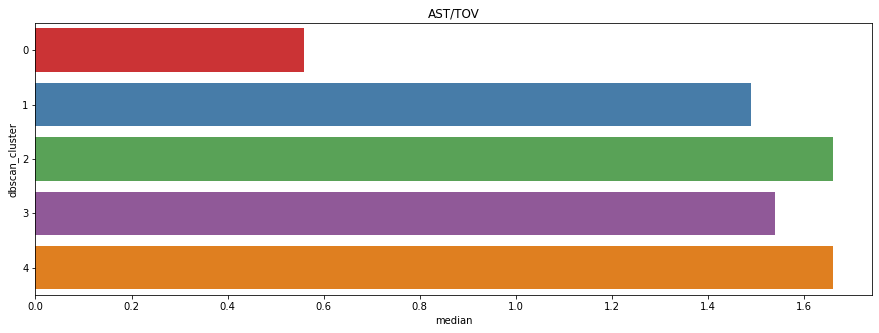

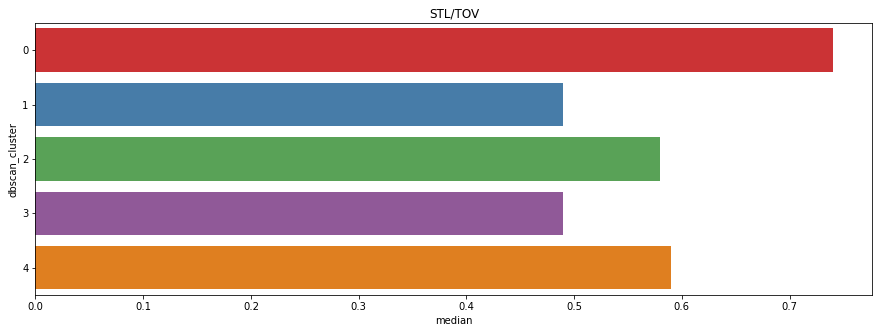

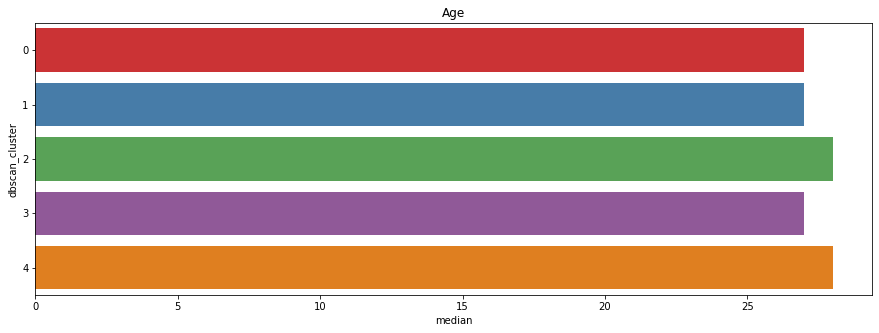

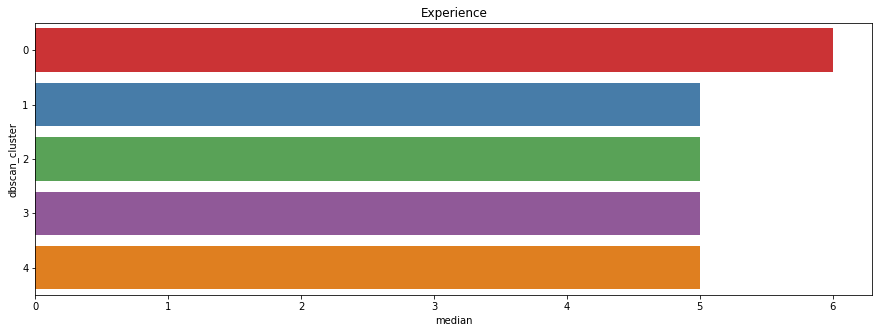

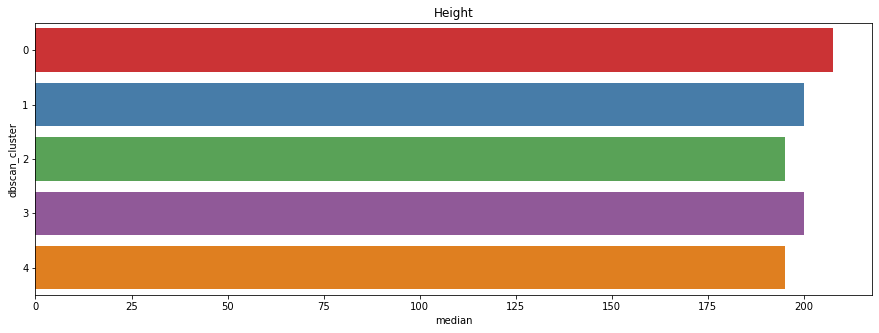

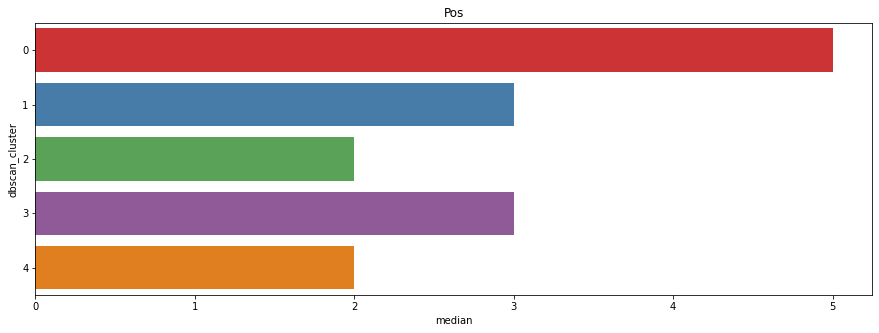

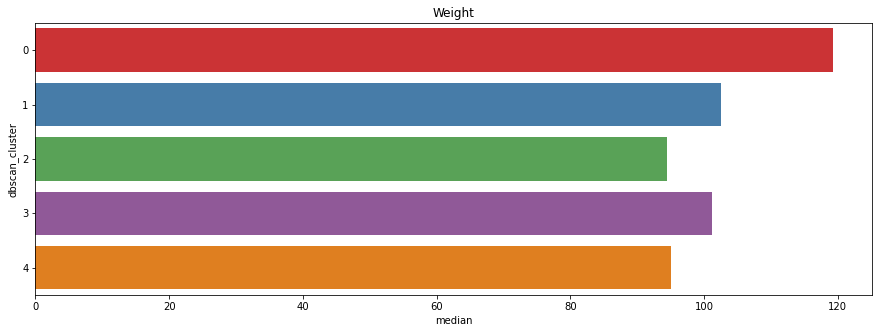

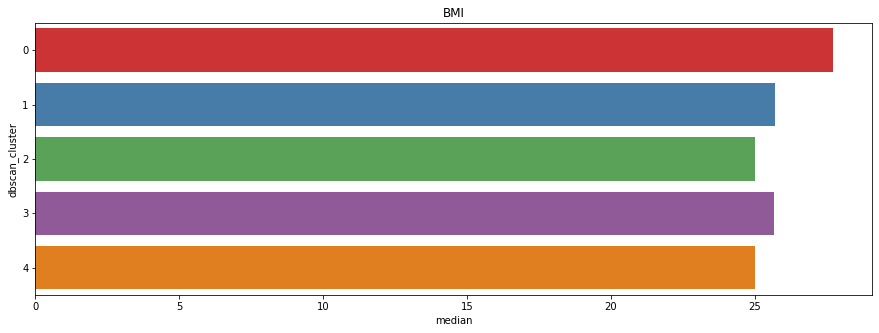

In [73]:
# comp_plots of num_col
for col in num_col:
    comp_plots(data, 'dbscan_cluster', col)

The key attributes stated before are indeed the main characteristics of its respective cluster. In 'FGM_x', half of the clusers are made shots.

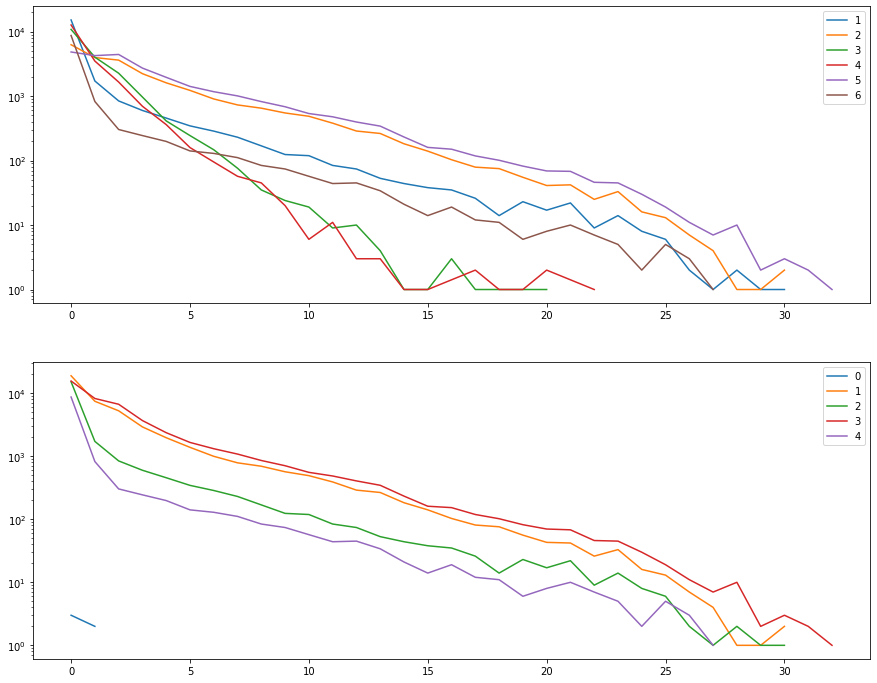

In [74]:
fig = plt.figure(figsize=(15, 12))

ax = fig.add_subplot(2, 1, 1)
for x in np.linspace(1, 6, 6):
    ax.plot((data[data.kmeans_cluster == x]['DRIBBLES'].value_counts().sort_index()))
ax.legend([1,2,3,4,5,6])
ax.set_yscale('log')

ax2 = fig.add_subplot(2, 1, 2)
for x in np.linspace(0, 4, 5):
    ax2.plot((data[data.dbscan_cluster == x]['DRIBBLES'].value_counts().sort_index()))
ax2.legend([0,1,2,3,4])
ax2.set_yscale('log')

KMeans clusters 2 and 5 dribble the most, while Kmeans clusters 3 and 4 dribble the least. This is consistent with the type of players of each clusters. 

In [75]:
data.query("Pos == 1")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                  5813
2               1                  8961
5               3                 10148
6               4                  3017
dtype: int64

In [76]:
data.query("Pos == 2")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                 6611
2               1                 8083
3               3                  251
4               1                  264
5               3                 9058
6               4                 3757
dtype: int64

In [77]:
data.query("Pos == 3")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                 4794
2               1                 5874
3               3                  331
4               1                  203
5               3                 6199
6               4                 2625
dtype: int64

In [78]:
data.query("Pos == 4")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                 2964
2               1                 1022
3               2                    1
                3                 9613
4               1                 9391
5               3                  746
6               0                    1
                4                 1547
dtype: int64

In [79]:
data.query("Pos == 5")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                  320
3               0                    4
                2                   32
                3                 8803
4               1                 9397
                4                    6
6               4                  160
dtype: int64

Bigger players (Pos 4 and 5) shot more 3 and 4 type

In [80]:
data.query("PTS_TYPE == 2")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
2               1                 23940
3               3                 18998
4               1                 19255
5               3                 26151
dtype: int64

In [81]:
data.query("PTS_TYPE == 3")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                 20502
3               0                     4
                2                    33
4               4                     6
6               0                     1
                4                 11106
dtype: int64

Odd dbscan clusters are 2-point shots. 

In [82]:
data.query("FGM_x == 0")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
1               2                 20502
3               0                     4
                2                    33
                3                 18998
5               3                 26151
dtype: int64

In [83]:
data.query("FGM_x == 1")[['kmeans_cluster', 'dbscan_cluster']].value_counts().sort_index()

kmeans_cluster  dbscan_cluster
2               1                 23940
4               1                 19255
                4                     6
6               0                     1
                4                 11106
dtype: int64

Even kmeans clusters are made shots.

Shot classification, based on kmeans clusters:
- 3PT, missed (kmeans 1)
- slash, made (kmeans 2)
- big, missed (kmeans 3)
- big, made (kmeans 4)
- slash, missed (kmeans 5)
- 3PT, made (kmeans 6)

Shot classification, based on dbscan clusters:
- outlier (dbscan 0)
- 2PT, made (dbscan 1)
- 3PT, missed (dbscan 2)
- 2PT, missed (dbscan 3)
- 3PT, made (dbscan 4)

## Model Saving

In [84]:
# create pipeline
pipeline = make_pipeline(SimpleImputer(), MinMaxScaler(), PCA(n_components=11),
                         KMeans(n_clusters=6, random_state=41))

In [85]:
# fit pipeline
pipeline.fit(data_select)
pipe_pred = pipeline.predict(data_select)

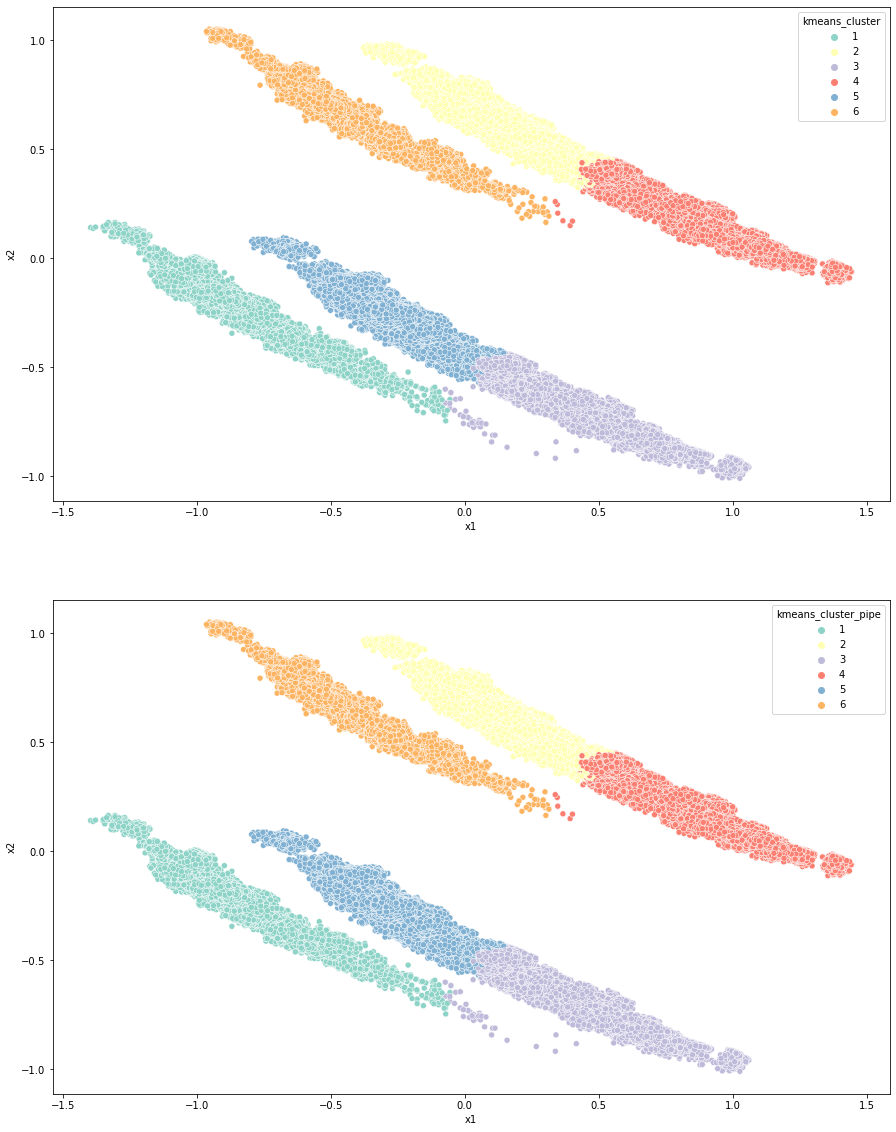

In [86]:
# cluster distribution plots (base vs pipeline kmeans)
pca_plot_df['kmeans_cluster_pipe'] = pipe_pred + 1

plt.figure(figsize=(15, 20))

plt.subplot(2, 1, 1)
sns.scatterplot(x='x1', y='x2', hue='kmeans_cluster', data=pca_plot_df, palette='Set3')

plt.subplot(2, 1, 2)
sns.scatterplot(x='x1', y='x2', hue='kmeans_cluster_pipe', data=pca_plot_df, palette='Set3')

plt.show()

## Model Inference

In [87]:
data_select.columns

Index(['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'FGM_x', 'FGA', 'FG%', '3PA',
       '3P%', 'FTA', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'PF',
       'AST/TOV', 'STL/TOV', 'Experience', 'Pos'],
      dtype='object')

In [88]:
inf_data = [39, 4, 720, 0, 4, 15, 2, 1, 1,
            1129, 49.6, 302, 37.1, 426, 85.4,            
            78, 361, 199, 106, 24, 87, 1.64, 0.88, 7, 3]

inf = pipeline.predict([inf_data])
print(inf + 1)

[2]


In [89]:
inf_data = [39, 4, 720, 0, 4, 15, 2, 1, 0,
            1129, 49.6, 302, 37.1, 426, 85.4,            
            78, 361, 199, 106, 24, 87, 1.64, 0.88, 7, 3]

inf = pipeline.predict([inf_data])
print(inf + 1)

[5]


In [90]:
inf_data = [39, 4, 720, 0, 4, 22.5, 3, 1, 1,
            1129, 49.6, 302, 37.1, 426, 85.4,            
            78, 361, 199, 106, 24, 87, 1.64, 0.88, 7, 3]

inf = pipeline.predict([inf_data])
print(inf + 1)

[6]


In [91]:
inf_data = [39, 4, 720, 0, 4, 15, 2, 1, 1,
            1199, 48.4, 263, 30.0, 649, 80.4,            
            160, 711, 234, 46, 122, 211, 1.04, 0.20, 2, 5]

inf = pipeline.predict([inf_data])
print(inf + 1)

[4]


## Conclusion

The shot data can be split into 4 or 6 clusters, depending on the algorithm. 4-clusters models (DBSCAN, Spectral Clustering, Agglomerative Clusering (linkage='single')) clusters are splitted by made/missed shot and 3P/2P shot, while 6-clusters models (KMeans,  Agglomerative Clusering (linkage='ward') 2P shot data are further split mainly by number of dribbles prior to shot.